In [57]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax

plt.style.use('intuitivebayes.mplstyle')
figsize = (24,12)

# Lesson Introduction: Art Class
Build intuition through creativity

## Section 10: How to a draw a line
* Showcase our challenge: Modeling C02 data
* Draw a line using linear regression
* Draw a couplle more lines with Bayesian Linear Regression

## Section 20: How to draw a wiggly line
* Discuss where plain linear regression misses
* How we can improve our model with additional term

## Section 30: Art a different way
* How would we intuitively build a curve

## Section 40: Similarity Functions
* Expanding

# Section 10: How to a draw a line
The first model that everyone tries (probably)

## Mauna Loa 
<center>
  <img src="img/Aa_channel_flow_from_Mauna_Loa.jpg"  />
</center>

Lets first talk about Hawaii, specifically Mauna Loa, which is quite beautiful as you can see here

On this island there is a research facility where they conduct experiments.

## Mauna Loa CO2 Experiment

<center>
    <div>
       <img src="img/9oyu_2ghf_141031.jpg" height="400" />
    </div>
</center>

- Been measuring C02 for the last X years
- A key experiment in the study of climate change
- Longest running continuous collection of atmospheric CO2 measurements


#  Mauna Loa CO2 dataset


In [58]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51)

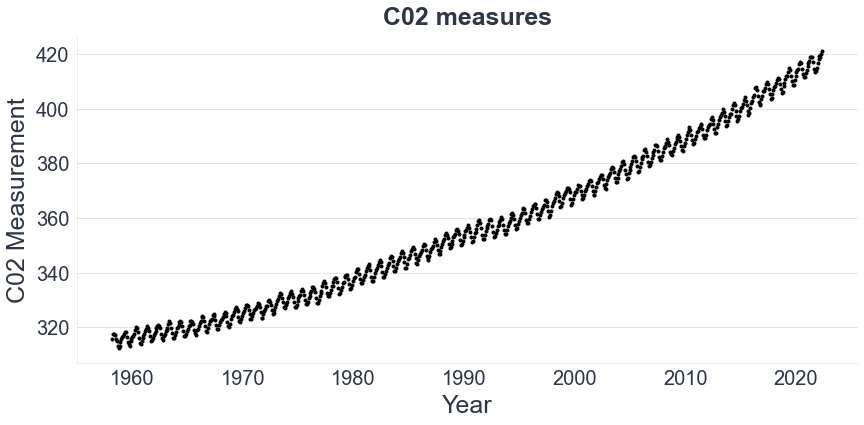

In [59]:
plt.figure(figsize=(14,6))
plt.plot(data["decimal date"], data["average"], "k.")
plt.title("C02 measures")
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

Here's the time series, theres a number of things we can note immediately. Is the trend, at a gance it looks roughly linear but perhaps not quite, it also has a seasonal pattern. Specifically it has some sort of cycle

## Zooming In

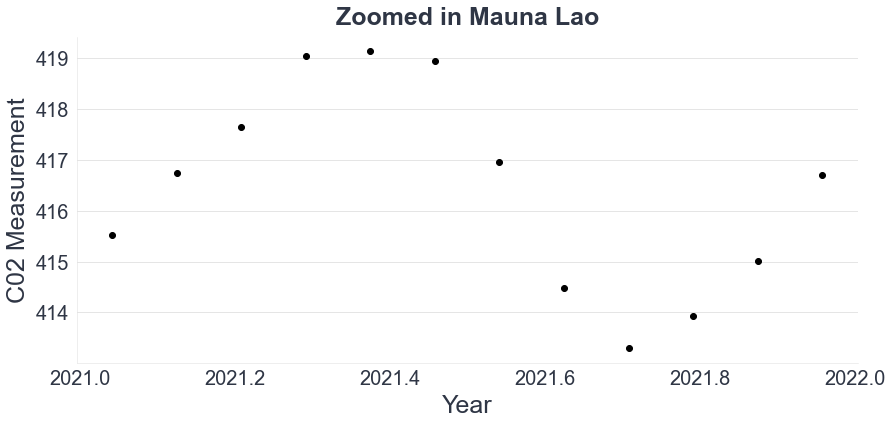

In [60]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"], "ko")
plt.title("Zoomed in Mauna Lao")
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

If we zoom in we can see a couple more features. The data has an an annual cycle which peaks in the spring, lowest in the fall

## Lets create a model
<center>
    <div>
       <img src="img/PyMC.png" height="400" />
    </div>
</center>

We're statisticians so buiding models is what we do. 

##  Lets create a model using a principled workflow

<center>
    <div>
       <img src="img/IB_Bayesian_workflow.jpg" height="400" />
    </div>
</center>


But we're also principled statisticians that follow the bayesian workflow
Let's start simple, and try and increase complexity.
Sometimes it's hard to resist the temptation to reach for the most "advanced" approach you know first.  It's always better to work up in this direction than the opposite.

We'lll

## Modeling the trend with a function

$$\huge{CO2\_Level = f(x)}$$

Keeping it simple lets model the trend.

For now lets ignore the small year to year variation First lets try fitting the whole thing with a straight line.  Let's ignore the annual up-and-down pattern (the technical term is called "seasonality", link to description of term) 

Lets also start simple and redefine the basics
Mathematical functions are the main tools we use to fit data.  Whether we are extrapolating or forecasting, or interpolating, we need something that given an `x`, outputs a `y`, or the range of plausible `y` values.  


## Linear Function

$$CO2\_Level = mx + b$$

Lets start by using familiar function you've seen before but before you skip this slide lets talk through it.
We're making a bold statement here. We're saying that if we have model parameters m and b, we can estimate C02_level by plugging in a value of X.



## Estimating the  parameters

$$CO2\_Level = \textbf{m}x + \textbf{b}$$

Now we still need to figure out What should we guess for $m$ and $b$?

- $\beta_0$ is the Y intercept, so what's the CO2 value here at year = 0?  Kind of hard.  It's usually good to normalize our data, so lets
rescale things so that the data starts near year "zero".  We can do this by subtracting the smallest x date from all our x values. Doing so won't change the results of our model, so long as we make sure to add it back in later.

# *A* way to pick an intercept


In [61]:
intercept = data.sort_values(["decimal date"])["average"].head(1)
intercept

0    315.7
Name: average, dtype: float64

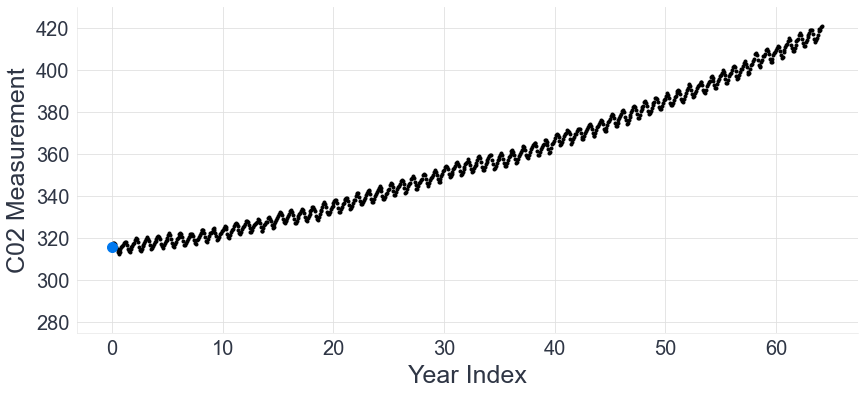

In [62]:
plt.figure(figsize=(14,6))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");

plt.grid(True)
plt.plot(0, intercept.values, marker="o", markersize=10)
plt.ylim([275, 430])
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

Let's just say we decide the intercept is where the first data point is. We're the modelers here so we can pick our parameters how we choose.

Lets just assume the first point is the intercept

# *A* way to pick a slope

In [63]:
xl = np.linspace(0, 70, 200)

possible_line1 = 315.7 + 1.5 * xl

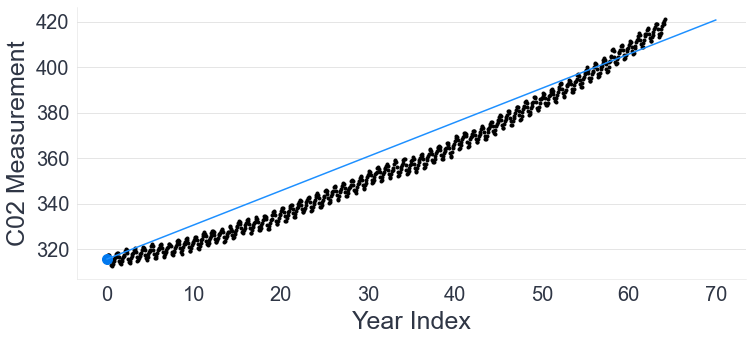

In [64]:
plt.figure(figsize=(12,5))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.")
plt.plot(0, intercept.values, marker="o", markersize=10)

plt.plot(xl, possible_line1, "dodgerblue")
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

**TODO**: Add rise over run picture

Now that we've picked an intercept all we need to do is pick a slope. Lets use rise over run

The slope parameter `m` might be a little easier.  Slope is defined as "rise over run", so lets try calculating. We might as well use that as one of our guesses.  Eyeballing it with upward curve makes this a bit tricky, but lets also try 300, and 290.   

The slope parameter `m` might be a little easier.  Slope is defined as "rise over run", so lets try calculating that at a few spots.  

## Multiple Estimations

In [65]:
xl = np.linspace(0, 70, 200)

possible_line1 = 315.7 + 1.5 * xl
possible_line2 = 300.0 + 2.0 * xl
possible_line3 = 290.0 + 2.0 * xl

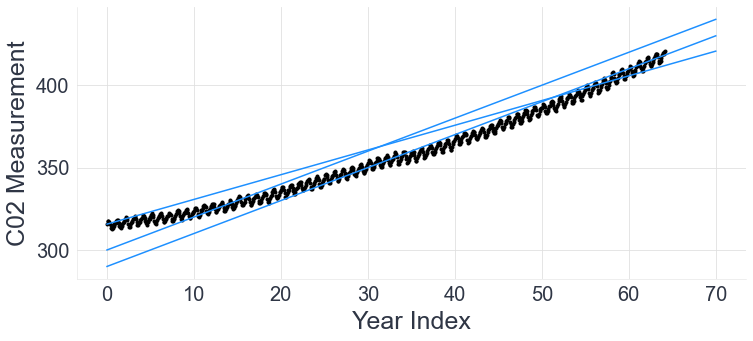

In [66]:
plt.figure(figsize=(12,5))
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");
plt.plot(xl, possible_line1, "dodgerblue")
plt.plot(xl, possible_line2, "dodgerblue")
plt.plot(xl, possible_line3, "dodgerblue")

plt.grid(True)
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

We can pick a couple more data points and repeat this process
- Lets start from year 10 to year 30:  Looking at the chart, at year 10, CO2 is about 320.  At year 30 CO2 is about 350.  That gives $\frac{350 - 320}{30-10} = 1.5$. - Year 30 to year 60: $\frac{410 - 350}{60-30} = 2.0$
- Year 40 to year 50: $\frac{385 - 370}{50-40} = 2.0$

Lets plug in our guesses and plot a few lines.

These are clearly pretty rudimentary guesses, but they at least look plausible?

How can we be more rigorous mathematically though? 

# OLS Regression

In [67]:
x = data["decimal date"].values - data["decimal date"].min()
X = np.vstack((np.ones(len(x)), x)).T 

y = data["average"].values

((b_est, m_est), _, _, _) = np.linalg.lstsq(X, y, rcond=None)
b_est, m_est

(305.59123653340896, 1.6081969456682896)

We can least squares using the OLS method for fun.

The least squares estimates for the y-intercept is 305.6, and for the slope its 1.6, which are pretty close to our previous guesses.

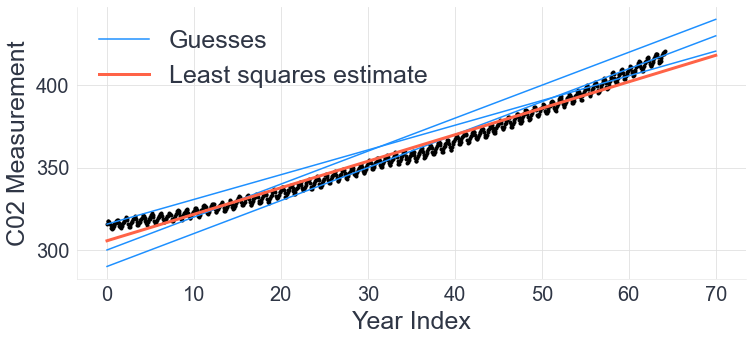

In [68]:
plt.figure(figsize=(12,5))
# plot data
plt.plot(data["decimal date"] - data["decimal date"].min(), data["average"], "k.");

# plot guesses
plt.plot(xl, possible_line1, "dodgerblue")
plt.plot(xl, possible_line2, "dodgerblue")
plt.plot(xl, possible_line3, "dodgerblue", label="Guesses")

# plot least squares estimate
plt.plot(xl, b_est + m_est * xl, color="tomato", lw=3, label="Least squares estimate");


plt.legend();
plt.grid(True)
plt.xlabel("Year Index")
plt.ylabel("C02 Measurement");

Now some of you might be saying, well obviously a better way is to minimize the sum of squares between each observed data point and the line to estimate the optimal m and b.

Some other people might even be a bit fancier and say, we're going to least squares regression or ordinary linear regression

And most people dont say either, but instead just load up excel or their favorite ML library, press run, get a line, and think thats theres no better way

# Bayesian Regression

In [69]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu = pm.Deterministic("mu", m * x_ + b)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])
    

But we're bayesian here, and we know how powerful this estimation method can be not to get one line, but all lines. Lets go ahead and use PyMC to get all possible lines **and** their relative plausability.

## Fit the model in PyMC

In [70]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


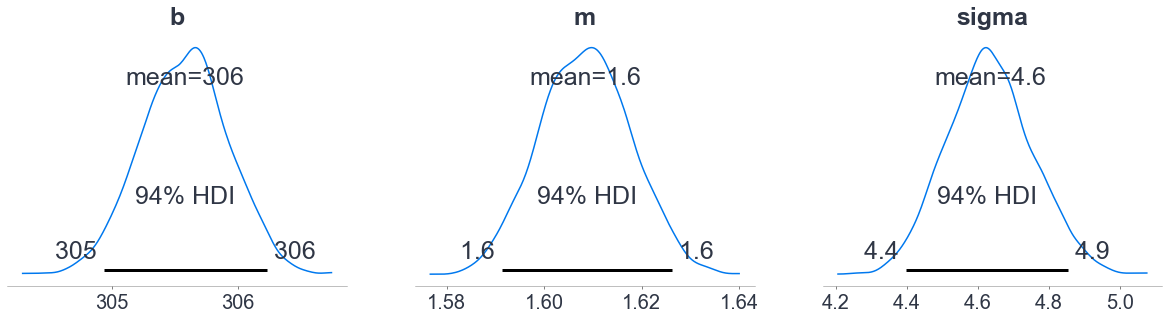

In [71]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "sigma"]);

We can see that with a Bayesian approach, we can let the model produce guesses, and associate each guess with a "plausibility score", or a posterior probablity. 


## Making Predictions

In [72]:
with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

We also can make predictions about future observations themselves

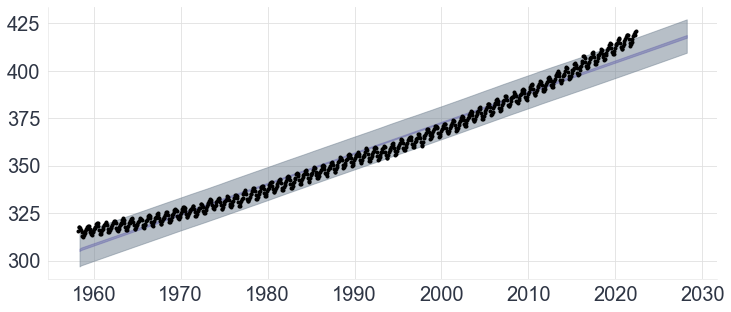

In [73]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");

plt.grid(True);

- Our guesses were pretty good, but PyMC's guesses are better
- Blue shaded is posterior predictive estimate of the line.  Since we have so much data, PyMC is pretty confident about this.
- Gray shaded is posterior predictive estimate of the data generated by the line.  It's wide enough to cover most of the data.

## Could we do better though?

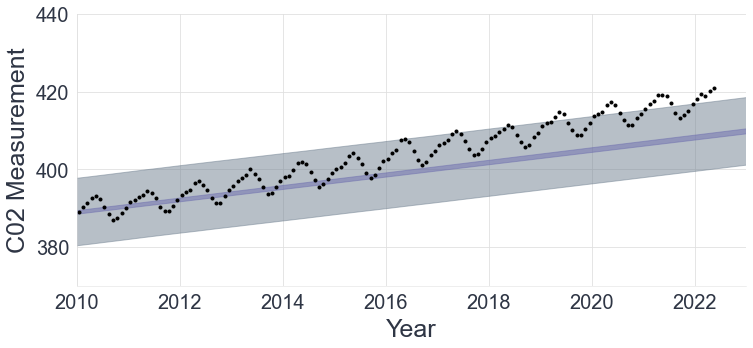

In [74]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");
plt.xlim(2010, 2023)
plt.ylim(370, 440)

plt.grid(True)
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

If we zoom in again though we can more clearly see that there's extra patterns were missing. In the next sections we'll address those as well. For now let's talk through our section recap

## Section Recap
* We want to estimate C02 Levels starting with a line

### Review
* Drew a single line using 
  * a elementary school method
  * Ordinary Least Square Regression
  * Drew many lines using Bayes Linear Regression

### Key takeaways
* Functions take inputs and provide us estimates
  * Needed to estimate the parameters
* We *assumed* a functional form mx+b


# Section 20:  How to draw a wiggly line
*Adding* more nuance

$$CO2\_Level = \textbf{m}x + \textbf{b}$$

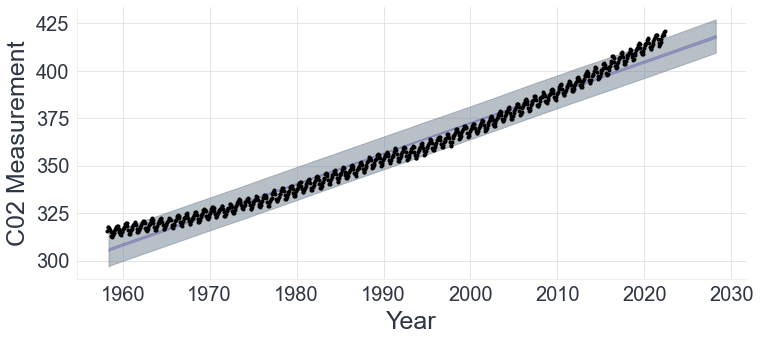

In [75]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");

plt.grid(True)

plt.xlabel("Year")
plt.ylabel("C02 Measurement");

In the last section we roughly we defined a linear model to capture the trend. We were able to estimate the parameters of that linear model using Bayesian method. However because our model only defined a line all, we got back straight lines

## What about all periodicity?

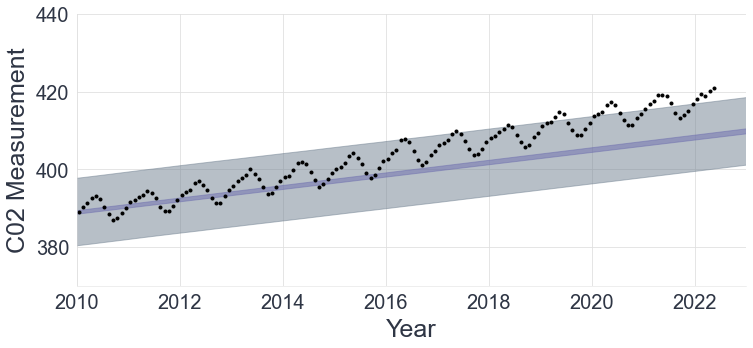

In [76]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

plt.plot(data["decimal date"], data["average"], "k.");
plt.xlim(2010, 2023)
plt.ylim(370, 440)

plt.grid(True)
plt.xlabel("Year")
plt.ylabel("C02 Measurement");

We say that were missing the squigliness though, more specifically referred to are periodicity.

## Zooming in on one period, or cycle

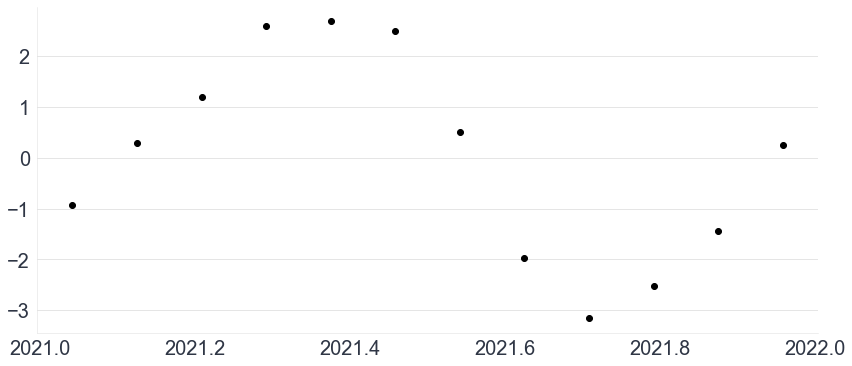

In [77]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko");

By inspecting these points up close we can see a familiar function. Try guessing what it is. We'll pause for a second to give a moment to think.

Did you say sine? Or did you guess cosine? Either way you're right

## Overlaying out random guess

$$CO2\_Level = sin(year* \pi)$$

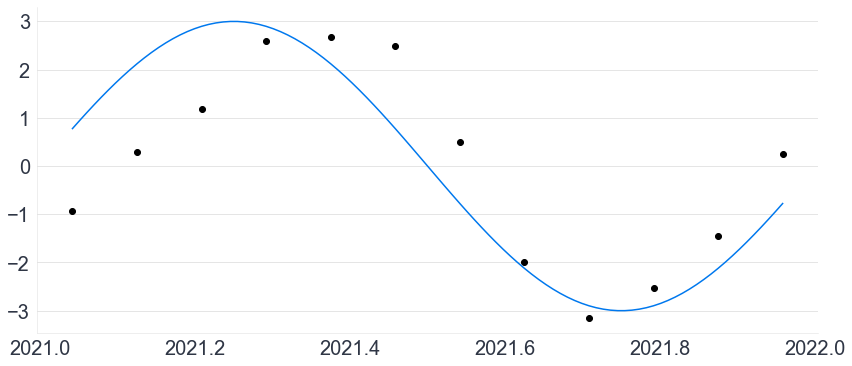

In [78]:
year = data[(data["decimal date"] > 2021) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko");

xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 100)
plt.plot(xl, 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi));

Like our trend we can use use the sine function parameterized by x, or year in this case, to model our data.

We guessed some parameters like before but it's great, there's certainly room for improvement.  This does give us some OK starting points though, and we can use these to help us set priors for our PyMC model.

- frequency: 1 (cycle per year)
- amplitude: 3.  After normalizing the observed data by subtracting the mean, we can see the cycle goes up and down from about -3 to 3. 
- phase: $-\frac{\pi}{2}$, this gets cosine to start at zero and increase first, which sort of matches the data, but should be a free parameter in the model.

## Sine waves don't go up

In [79]:
data["decimal date"]
sin_component = 3*np.cos(2 * np.pi * xl)

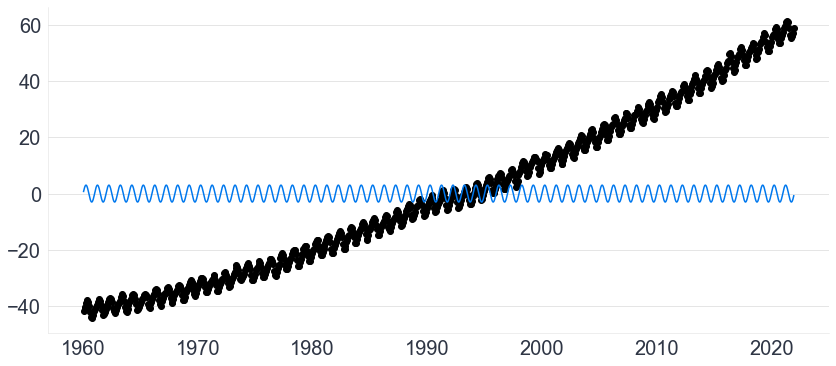

In [80]:
year = data[(data["decimal date"] > 1960) & (data["decimal date"] <= 2022)]

plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"] - year["average"].mean(), "ko");

xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 10000)
plt.plot(xl, 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi));

We have another problem though, sine waves don't go up but we have a solution for that

## Additive models

In [81]:
xl = np.linspace(year["decimal date"].min(), year["decimal date"].max(), 10000)

sin_component = 3*np.cos(2 * np.pi * xl * 1.0 - 0.5 * np.pi)

# We bot these from the Bayesian estimation
m, b =1.6, 306
linear_component = m*(xl-year["decimal date"].min()) + b

squiggly_line = linear_component + sin_component

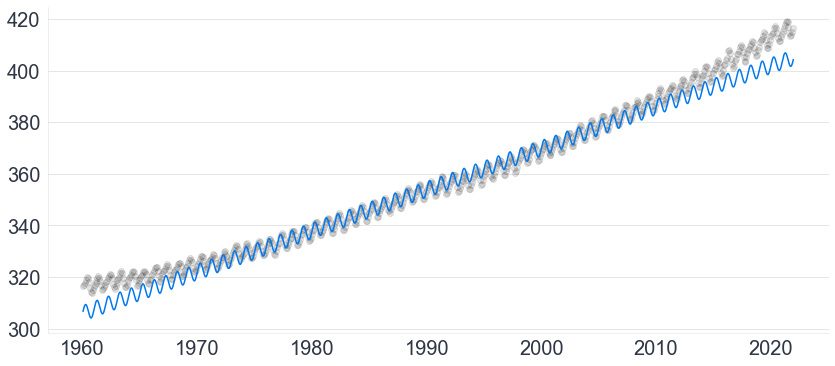

In [82]:
plt.figure(figsize=(14,6))
plt.plot(year["decimal date"], year["average"], "ko", alpha=.1);

plt.plot(xl, squiggly_line);

What we could do is add our linear term and our sin wave together to create a new model. Now we get the effects of both together. Better, now instead of guessing parameter let's use Bayesian methods to estimate our parameters again.

## Bayesian Additive model

In [83]:
with pm.Model() as model:
    b = pm.Normal("b", mu=300, sigma=100)
    m = pm.Normal("m", mu=0.0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    x_ = pm.MutableData("x", data["decimal date"] - data["decimal date"].min())
    mu_linear = pm.Deterministic("mu_linear", m * x_ + b)
    
    
    A = pm.HalfNormal("A", sigma=5)
    phi = pm.Normal("phi", mu=-np.pi / 2, sigma=0.1)
    freq = pm.Normal("freq", mu=1.0, sigma=0.1)
    mu_periodic = pm.Deterministic("mu_periodic", A * pm.math.cos(2 * np.pi * x_ * freq + phi))
    
    mu = pm.Deterministic("mu", mu_linear + mu_periodic)
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=data["average"])
    
    
with model:
    idata = pm.sample(tune=2000, chains=2, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m, sigma, A, phi, freq]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 28 seconds.


You'll notice a couple of extra terms now.

## Our parameter estimates

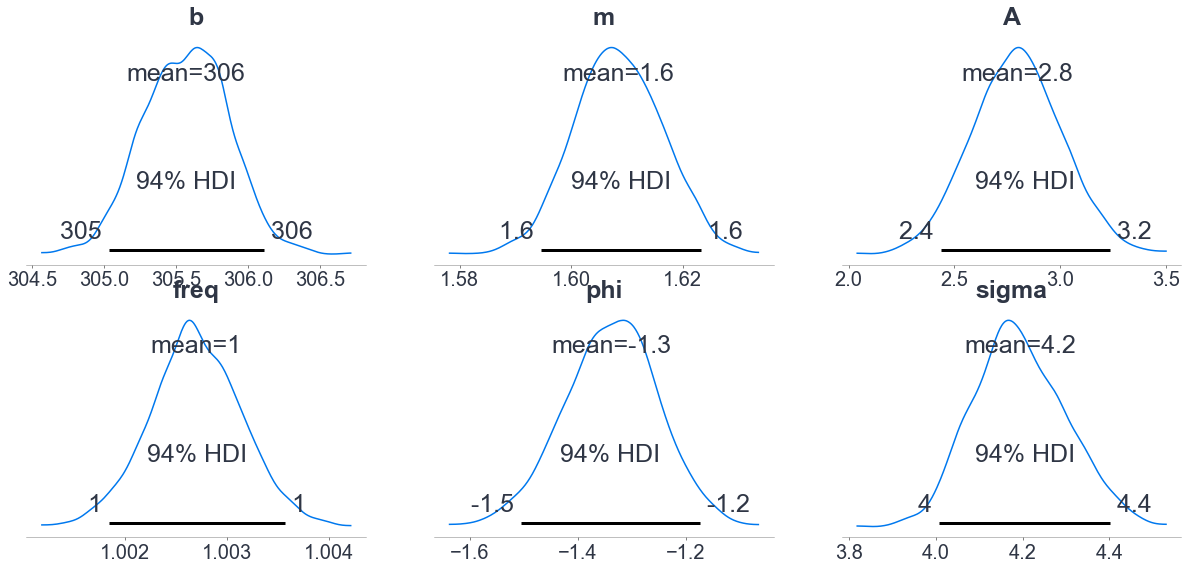

In [84]:
az.plot_posterior(idata.posterior, var_names=["b", "m", "A", "freq", "phi", "sigma"]);

Now using ArviZ let's plot the posterior 

- It was a bit tricky to get the sampler to converge, but now it looks like the results are sensible.  The parameter estimates are also somewhat in line with our guesses.  
- Now lets look at the posterior predictive and draw some samples

In [85]:
xl = np.linspace(0, 70, 1000)

with model:
    pm.set_data({'x': xl})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])
    idata.extend(ppc)

## Making prections

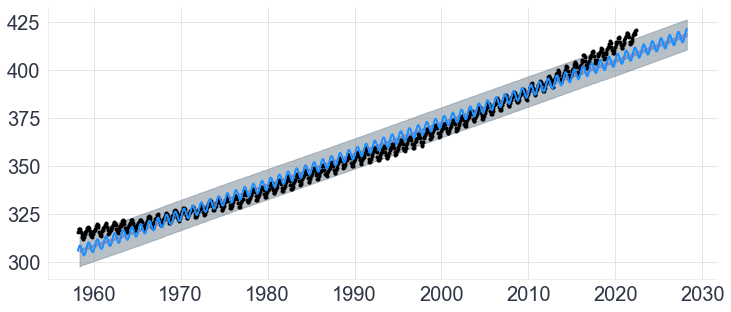

In [86]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.mu), color="slateblue")
az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

plt.plot(data["decimal date"], data["average"], "k.");
plt.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue');

plt.grid(True);

Usnig 
- the results look similar to the straight line model, except when we look at individual samples of `mu` we can see the seasonal pattern reflected. 
- Lets zoom in also and look at the small scale structure

## Zooming into our posterior predictive

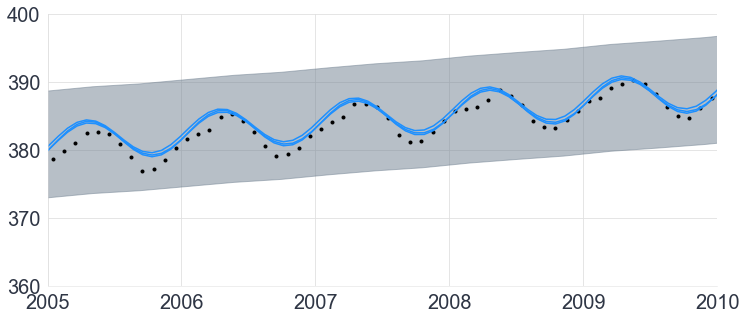

In [87]:
plt.figure(figsize=(12,5))

az.plot_hdi(x=xl + data["decimal date"].min(), hdi_data=az.hdi(idata.posterior_predictive.y), color="slategray")

mu_samples = idata.posterior_predictive.mu.stack(sample=["chain", "draw"]).isel(sample=[1,2,3]).values

plt.plot(data["decimal date"], data["average"], "k.");
plt.plot(xl + data["decimal date"].min(), mu_samples, color='dodgerblue');

plt.grid(True);
plt.xlim([2005, 2010]);
plt.ylim([360, 400]);

Even at the best looking part of the curve, there are still pretty obvious issues still here.

What is wrong:
- Linear term seems insufficient.  Upward increasing trend
- "Cosine" seems insufficient.  Is it a perfect sine wave?  Or is something that's almost a sine wave, but still has a repeating pattern.
- How much more fine structure are we missing in the data?

Now you might say well lets go add another function, but where does it stop?

- With this functional approach, nothing stops us from forecasting infinitely far into the future.  Is that reasonable?

## The steps to our current approach

1. Guess at a functional form of the series
2. Estimate parameters for that function
3. See what's wrong
4. Go back to step 1

Continuing with this approach, what might we try?  Coming up with functional forms is difficult and it doesnt always work!  Also, how much do we care about these parameters? We might just to know what the CO2 levels might be, not necssarily care about the components of the model or their parameters

Now don't get us wrong, additive models are a valid approach in many situations, but that's not our case. Nor is this is the right course! The good news is there is another approach, but before we get ahead of ourselves lets talk through our section recap

## Section Recap
* Functions can be added together to create new models
  * Knowing as additive models
* The modeler still needs to decide what the functions are
  * And estimate the parameters even if they're not if interest
* With the C02 estimation even with an extended additive model there's issues

In [88]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pymc as pm


In [89]:
import pymc.sampling_jax

In [90]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51)

# Section 30: Art a different way
There's more than one way to draw a curve

## Mondrian's Art Style

<center>
  <img src="img/Mondrian.jpg"  />
</center>

When we said art class we weren't kidding. Here's piece of art from Mondrian and as you can tell he had a very particular mindset when making this

## Jackson Pollock's Art Style

<center>
  <img src="img/Pollock.jpg" style="height:750px";/>
</center>

And here's one from Jackson pollock. Its still art, but there's a very different mentality behind how it was created. Keep that in mind as we introduce a new "art" style for our Mauna Loa challege in this section

## Revisiting our linear fit

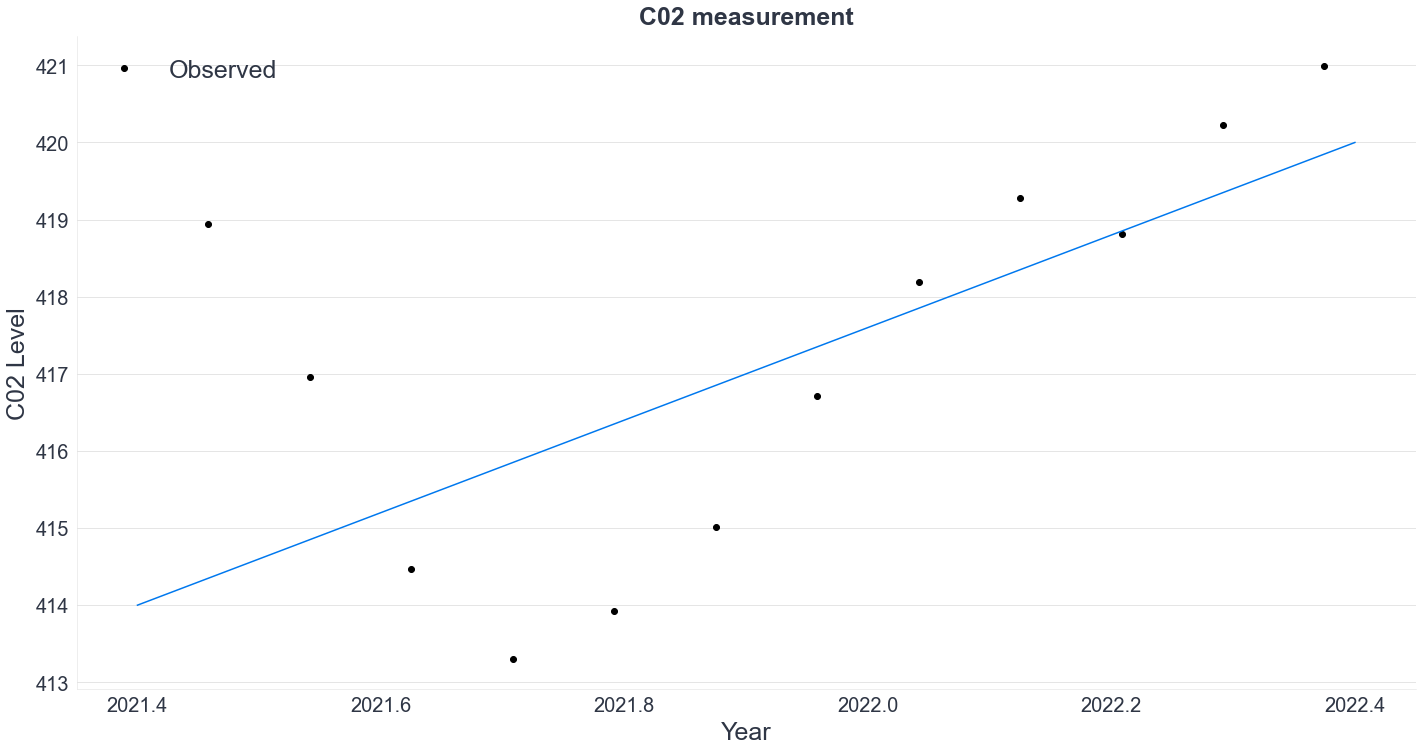

In [141]:
last_12_obs = data.sort_values("decimal date").tail(12)

# These are just guesses, need replace with the real OLD estimate
rise = 6
min_x, max_x = 2021.4, 2022.4
run = 2022.4 - min_x

m = rise/run
b = last_12_obs["average"].min()

fig, ax = plt.subplots(figsize=figsize)

def plot_data(ax):
    ax.plot(last_12_obs["decimal date"], last_12_obs["average"], "ko", label="Observed")
    ax.set_title("C02 measurement")
    ax.set_xlabel("Year")
    ax.set_ylabel("C02 Level");
    return

def plot_best_fit_line(ax):
    x_est = np.linspace(min_x, max_x, 100)
    y_est = m*(x_est - min_x) + 414
    ax.plot(x_est, y_est)
    return

plot_data(ax)
plot_best_fit_line(ax)
plt.legend();

Let's revisit our Mondrian style analysis. Remember our goal here is to estimate the C02 levels on any date, not just the observed dates. 

We decided to use a line as our first model. Here's the line we fit we fit earlier. Because we're currently fitting lines like Mondrian we're fixed to a strict functional fit. Given that this is the best we could do.

## Revisiting *how* we got to this line

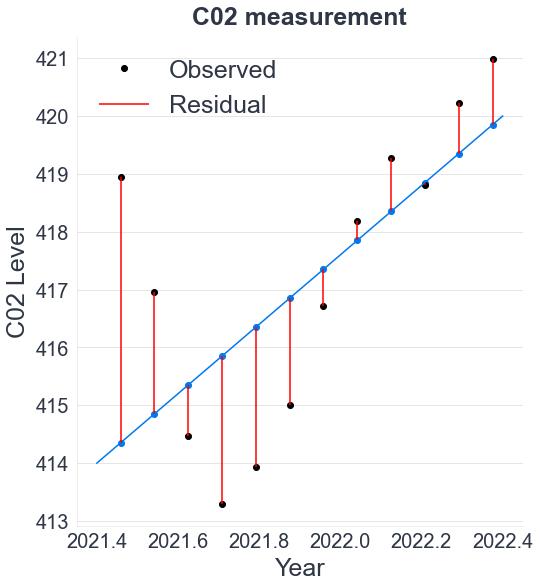

In [142]:
fig, ax= plt.subplots(figsize=(8,9))

plot_data(ax)
plot_best_fit_line(ax)

# Plot Residuals
y_est_obs = m*(last_12_obs["decimal date"] - min_x) + 414

for x, y_obs, y_est in zip(last_12_obs["decimal date"].values, y_est_obs, last_12_obs["average"]):
    if x == last_12_obs["decimal date"].min():
        label = "Residual"
    else:
        label= ""
    plt.vlines(x, np.min([y_obs, y_est]), np.max([y_obs, y_est]), label=label, color="r")

ax.scatter(last_12_obs["decimal date"], y_est_obs)

plt.legend();

1. Defined a function
  * $CO2\_Level = \textbf{m}x + \textbf{b}$

2. Determined the "best" parameters given **all** the observed data
  * Minimizing sum of residuals
  * Using Bayesian estimation (which is basically the same thing)

3. Now we can make a prediction at **any** X

Here's the steps for us to get here. We...

The red lines here are the residuals that we're trying to minimize so we can get the "tighest" line

## Our Prediction for 2021.91

In [93]:
date_of_interest = 2021.91

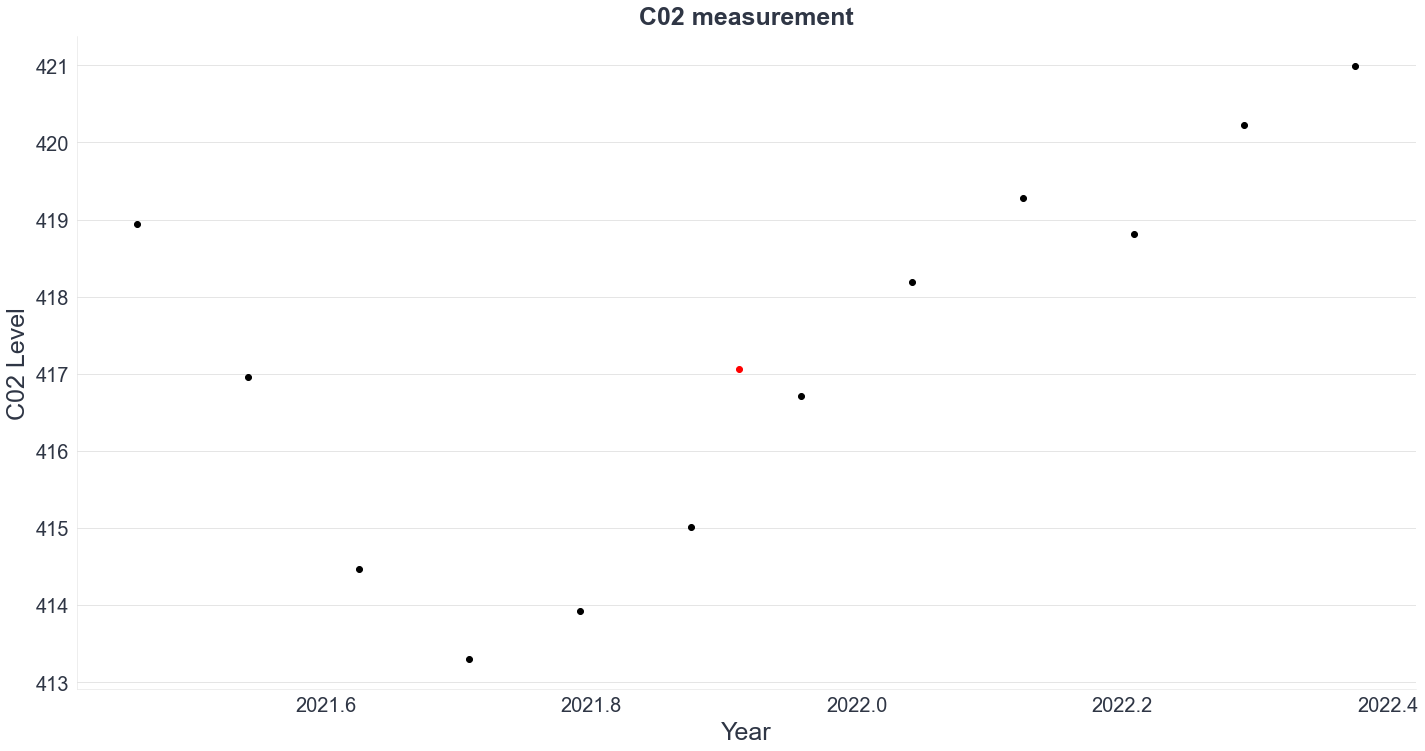

In [94]:
plt.figure(figsize=figsize)
plot_data()

est_2022 = m*(date_of_interest - min_x) + 414
plt.scatter(date_of_interest, est_2022, c="r");

## Rethinking our estimate for 2021.91

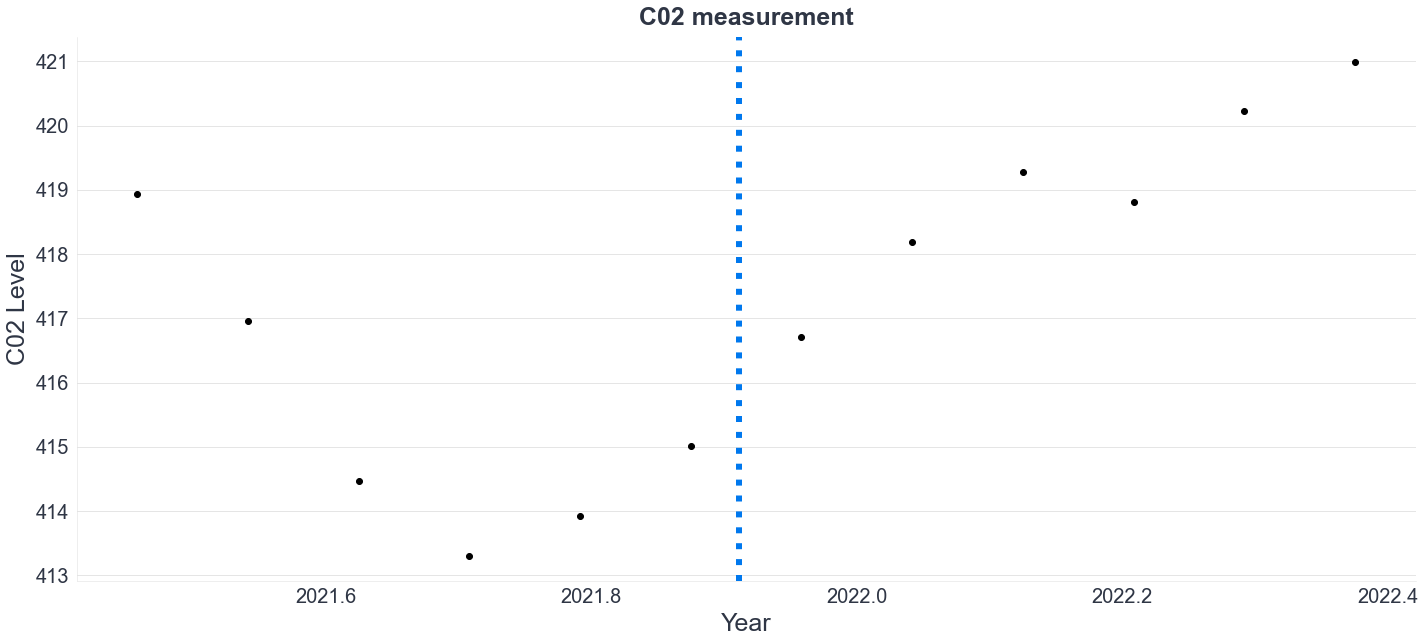

In [95]:
plt.figure(figsize=(24,10))

plot_data()
plt.axvline(date_of_interest, linestyle="dotted", lw=6);

Let's just focus on one date. 2022.00. If we needed pick a point for this what where would we put it?

If we use our previous approach, since were just minimizing sum of squares, the error for this dot way far on the left, can have a greater impact for our prediction at 2022, than the points right next to 2022 our point of interest.

** Fadi highlight dot all the way to the left, and then

## Four possible estimated C02 Levels

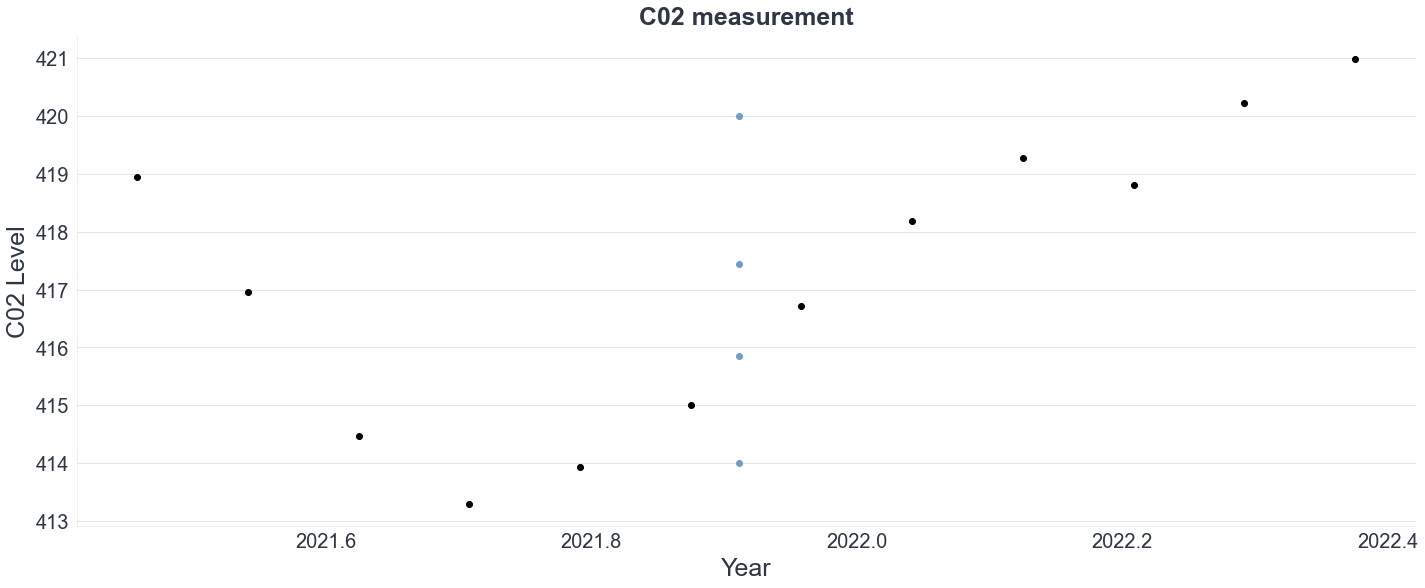

In [96]:
plt.figure(figsize=(24,9))
plot_data()

y_vals = (414, 415.86, 417.45, 420)
for y_val in y_vals:
    plt.plot(date_of_interest, y_val, marker="o", c="C5")

## Using our intuition to make estimates


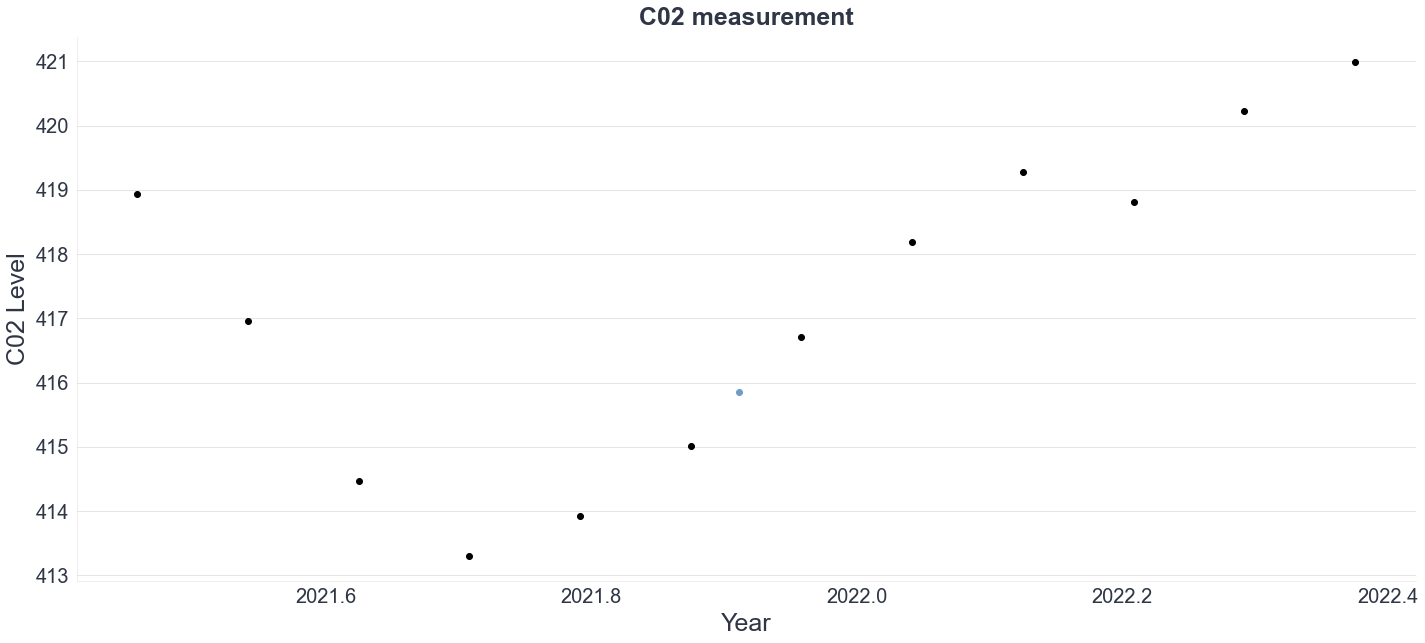

In [97]:
plt.figure(figsize=(24,10))
plot_data()
plt.plot(date_of_interest, y_vals[1], marker="o", c="C5");

Our guess is you took a look at the points that were closest to 2021.9. That would be the one to the left and the right of the out date of interest. You then "eyed out" where the correct placement was. That's what we did too.

We also believe you *did not* consider these points all the way to the left and the right, or if you did they mattered a lot less than the immediately adjacent points

## Formalizing our intuition

In [98]:
(last_12_obs
     # Get the distance to all other points
    .assign(distance=np.abs(last_12_obs["decimal date"] - date_of_interest))
     
     # Sort by distance
    .sort_values("distance")
 
     # Take the top two
    .head(2)
     # Get the average
     ["average"].mean())

415.86

Because were mathematicians we can formalize this. We can take the values of the two points closest and take the average to figure out the y distance.

Lets do that again here for this point and this point. So far so good right! 

Writing down our steps.

1. Look at the two closest points
2. Take the average

##  Freeing ourselves of the functional form


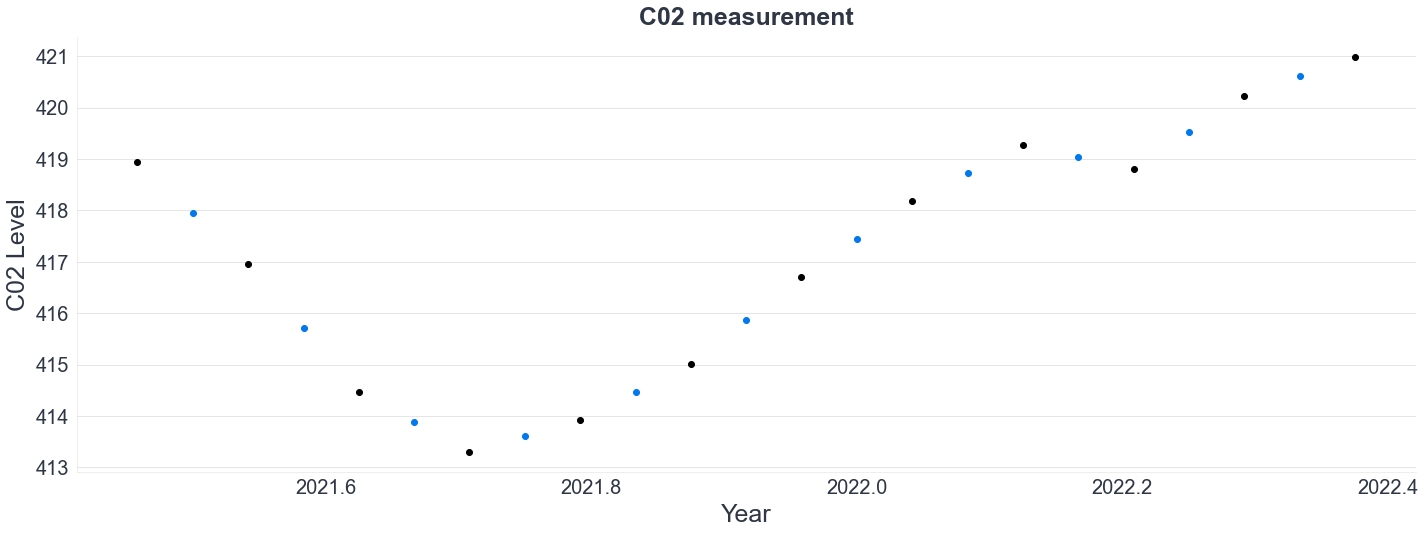

In [99]:
plt.figure(figsize=(24,8))
plot_data()


vals = last_12_obs[["decimal date", "average"]].rolling(window=2).mean()

plt.scatter(vals["decimal date"], vals["average"], marker = "o");

This is amazing now we dont need to define a functional form. This method should work equally well on any arbitrary function. Lets now fill in all the other values

## Breaking our intuition



In [135]:
date_of_interest = 2021.90

In [136]:
plt.figure(figsize=figsize)


plot_data()
y_val = (last_12_obs
    .assign(distance=np.abs(last_12_obs["decimal date"] - date_of_interest))
    .sort_values("distance")
    .head(2)
    ["average"].mean())

plt.scatter(date_of_interest, y_val);

TypeError: plot_data() missing 1 required positional argument: 'ax'

<Figure size 1728x864 with 0 Axes>

As we move closer to the dot on the right, we'd assume that our estimated points would go up, since the dot on the right "matters more" as its closer. But because were just selecting the two closest points and averaging that doesn't work

## Moving average fit

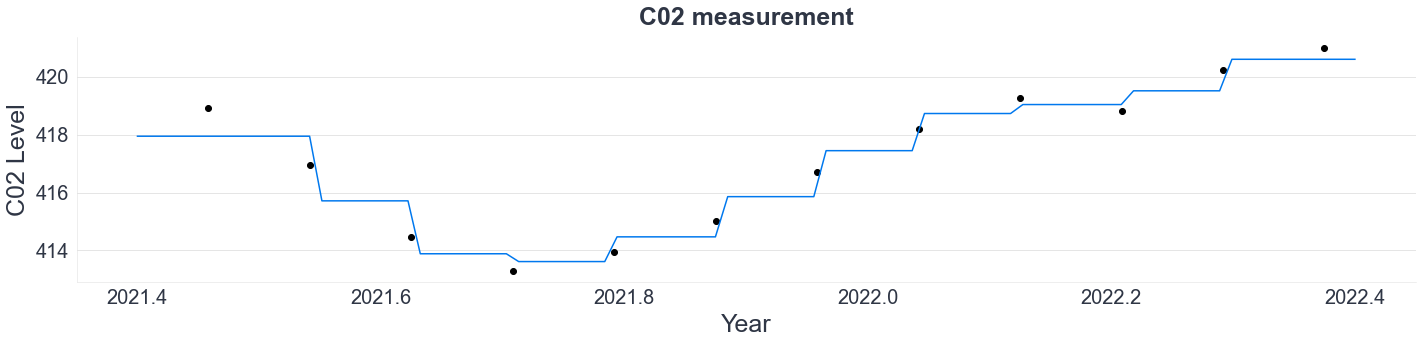

In [102]:
plt.figure(figsize=(24,4.5))
plot_data()
# Don't do this in real life, its very computationally wasteful
x = np.linspace(2021.4, 2022.4, 100)
y = []
for point_of_interest in x:
        
    y_val = (last_12_obs
        .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
        .sort_values("distance")
        .head(2)
        ["average"].mean())

    y.append(y_val)
plt.plot(x, y);

This is what the fit looks like if we plot more points between data points. Now nothing is inherently wrong with this, moving average fits are used in time series all the time, but its not what were looking for

## What if we include more data in the average?

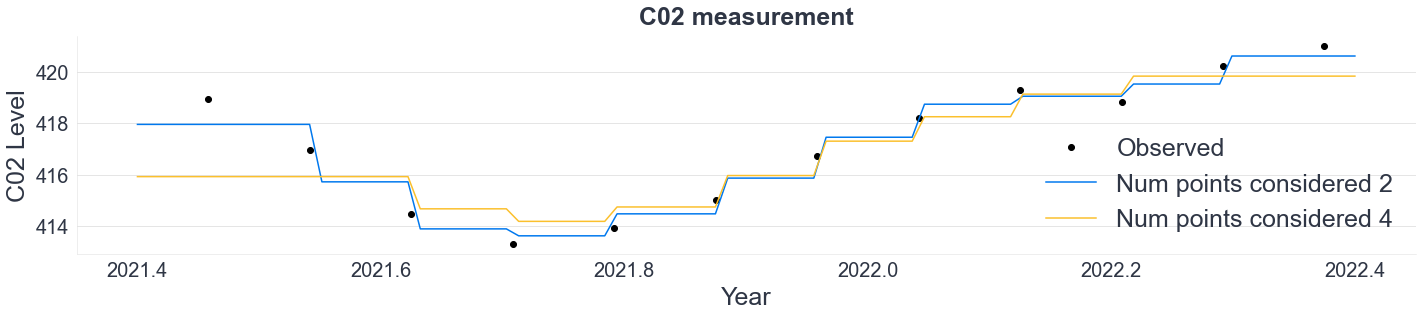

In [103]:
plt.figure(figsize=(24,4))
plot_data()
x = np.linspace(2021.4, 2022.4, 100)


for num_points_considered in (2, 4): 
    y_vals = []
    for point_of_interest in x:  
        y_val = (last_12_obs
            .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
            .sort_values("distance")
            .head(num_points_considered)
            ["average"].mean())

        y_vals.append(y_val)
    plt.plot(x, y_vals, label = f"Num points considered {num_points_considered}")
plt.legend();

You might say, why only two closet data points were throwing away information. Youre right we are and its a problem. Here we picked

We made an exercise so be sure to do it to see what were talking about 

In the next section we'll show you how to overcome these of a step wise fit, and adjusting the influence of the data, all with an neat mathematical trick. For now lets go to the section recap

## Same as equal weighting the data

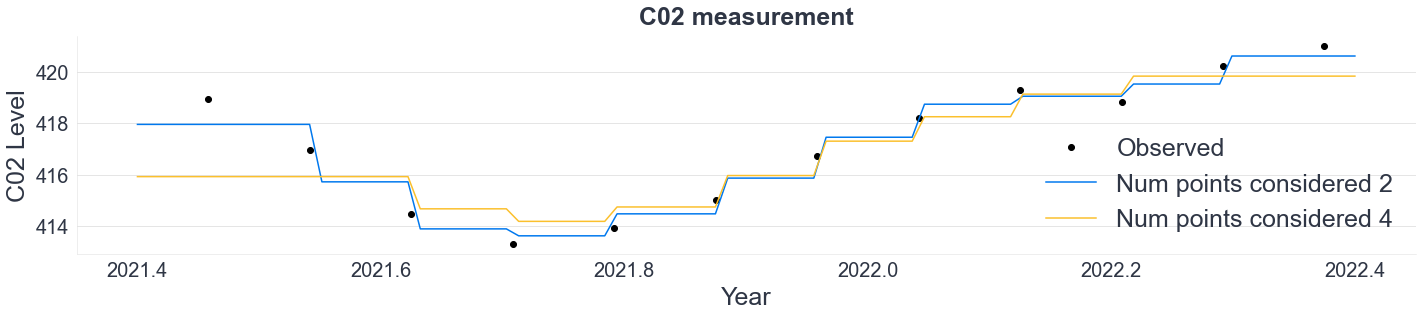

In [105]:
plt.figure(figsize=(24,4))
plot_data()
x = np.linspace(2021.4, 2022.4, 100)

for num_points_considered in (2, 4): 
    y_vals = []
    for point_of_interest in x:  
        y_val = (last_12_obs
            .assign(distance=np.abs(last_12_obs["decimal date"] - point_of_interest))
            .sort_values("distance")
            .head(num_points_considered)
            ["average"]
            
            # Note the change here
            .sum()/num_points_considered)

        y_vals.append(y_val)
    plt.plot(x, y_vals, label = f"Num points considered {num_points_considered}")
plt.legend();

We can equivalently think of our model as using a weighted average for the estimates.  In this last case where we chose 2 neighbors, those two neighbors each get a weight of 50%, or 0.5, and all the other data points get weights of zero.  

## Section Recap
* There are ways to find that are *not* optimizing over hand selected functional models
  * In this paradigm every data point whether close or far to a particular x value has the same weight
* Intuitively it makes sense that closer observed data should be more influential
* Windowed averaging is one method
  * Works great when the x value of interest is at the midpoint of two observations
  * Does not work so great when we start moving closer to one point or another

## Weighted averages

This will be useful later, but we can equivalently think of our model as using a weighted average for the estimates.  In this last case where we chose 2 neighbors, those two neighbors each get a weight of 50%, or 0.5, and all the other data points get weights of zero.  

#  Similarity Functions
Weighting the data

In the last section we started to think about modeling functions in a slightly different way.  We've freed ourselves from trying to come up with specific functional forms, but using the average of the y values of our nearest neighbor data points gives us a result that looks the most Mondrian of all!  In this section we'll keep going down the road to Jackson Pollacks stochastic processes.  Along the way, we'll build from the ground up a concept, aptly called a **kernel** that is at the core of many many machine learning algorithms, including Gaussian processes.  

## Location, location

<center>
     <img src="img/Farmhouse.png"  />
</center>

We've seen that is hard to come up with a heuristic to pick the right number of neighboring data points.  And, when we do this, our models produce results that are jumpy, Mondrian, and probably not very realistic.  Let's take one step further and reframe things in terms of **distance**.  What if all your neighbors are very far apart? 


## Location,
## Location


<center>
     <img src="img/Stackedhouse.png"  />
</center>

Or, what if they're all stacked on top of each other?

The number of neighbors that matter is clearly context dependent.  The underlying thing that's really determining change is distance, or equivalently, similarity. 

If you were standing on the porch of the farmhouse in the last slide, how far would you have to walk until you stop seeing farmhouses and start seeing the suburbs and then, the cityscape in picture 2? 


## Similarity, aka, the Kernel



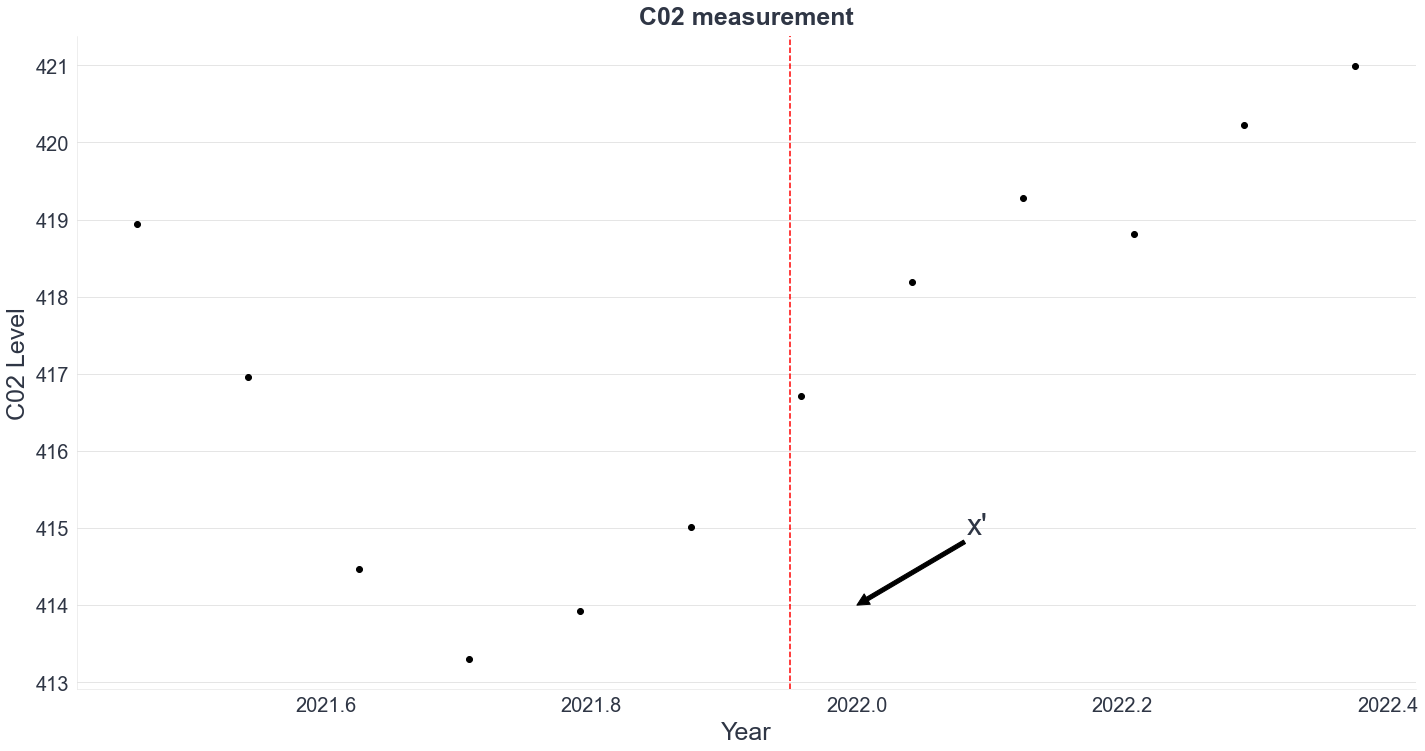

In [120]:


fig = plt.figure(figsize=figsize)
ax = fig.gca()

plot_data(ax);
plt.axvline(x=date_of_interest, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

Let's go back to Mauna Loa and apply this concept to refine the nearest neighbor idea from the previous section.  We can actually start here and use our intuition to design a simple *kernel* function from the ground up.

Distance, or similarity, in the CO2 data set isn't about walking or driving distance.  Instead, it's about time, which weve already called the x-axis.  Let's pull up our data, and like we did before, let's start at Jan 1, 2022.  But this time let's also introduce a bit of notation.  Let's call this point $x'$, so $x' = 2022.0$.  We put a vertical red line here on the plot.  Just to be sure, let's also make sure our terms are straight.  **Kernel = Similarity**, and distance is like, the opposite of similarity. 

## Distance

$$ 
\Huge
{d = ( x - x' )^2}
$$

Now let's define a distance, which we'll call $d$.  The distance we care about is the difference from our "test point" x', to anywhere else on the x axis.  Let's also make it a positive number (does negative distance mean here?) by squaring it, 

Yes, we could have also used the absolute value here to make it positive.  EXERCISE:  Try running the rest of the code using absolute value here instead of squaring.  

## Calculating the distance our two favorite points

In [119]:
distance_func = lambda x: np.square(x["decimal date"] - date_of_interest)
(last_12_obs
     # Get the distance to all other points
    .assign(distance=distance_func)
    .head())

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc,distance
759,2021,6,2021.4583,418.94,416.51,28,0.65,0.23,0.241769
760,2021,7,2021.5417,416.96,416.60,30,0.71,0.25,0.166709
761,2021,8,2021.6250,414.47,416.46,26,0.72,0.27,0.105625
762,2021,9,2021.7083,413.30,416.88,27,0.29,0.11,0.058419
763,2021,10,2021.7917,413.93,417.28,29,0.35,0.12,0.025059


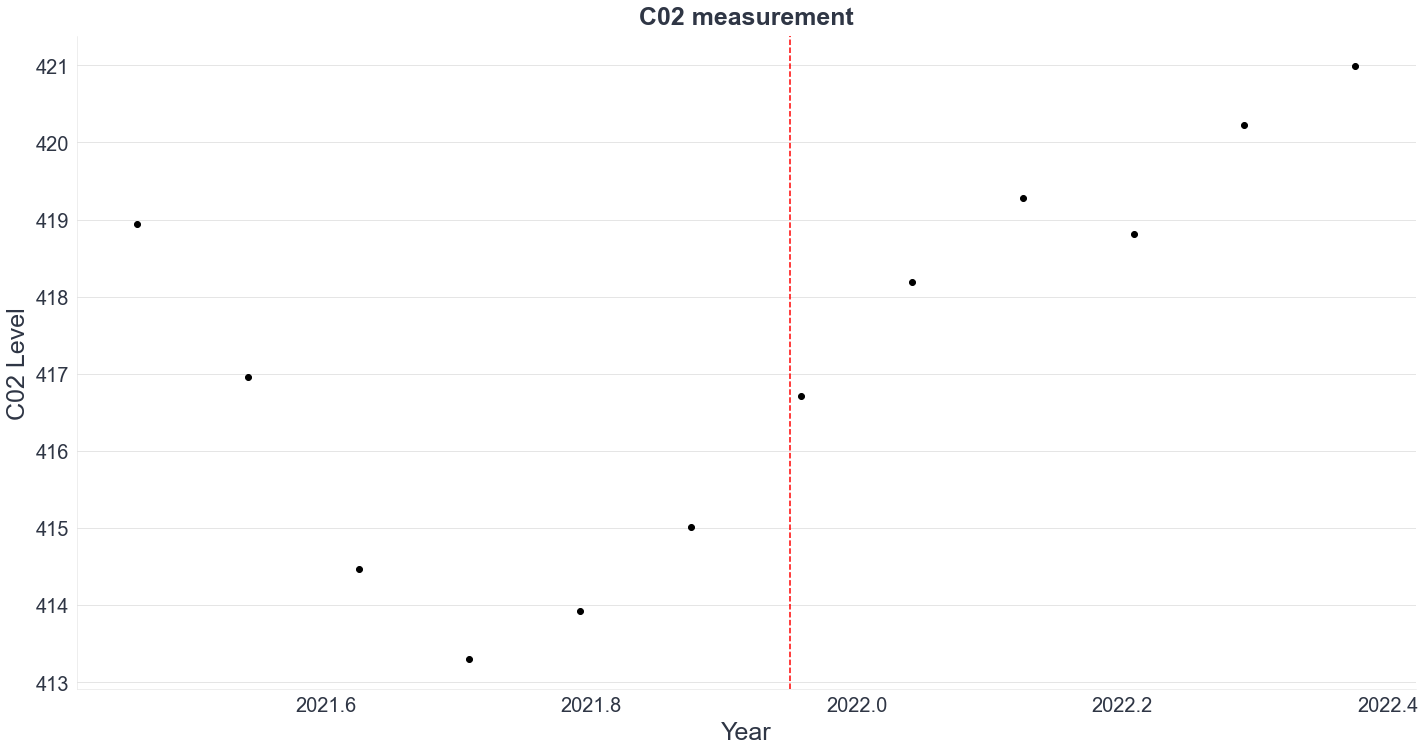

In [118]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

plot_data(ax)
plt.axvline(x=date_of_interest, color="r", linestyle="--");

Notice how the distance calculation between the two points here. The difference in the final value means were weighting one of the points more than the other. Also note how even though the calculation within the parans is negative, when we square it it turns positive. 

## Plotting the distance to *every* x

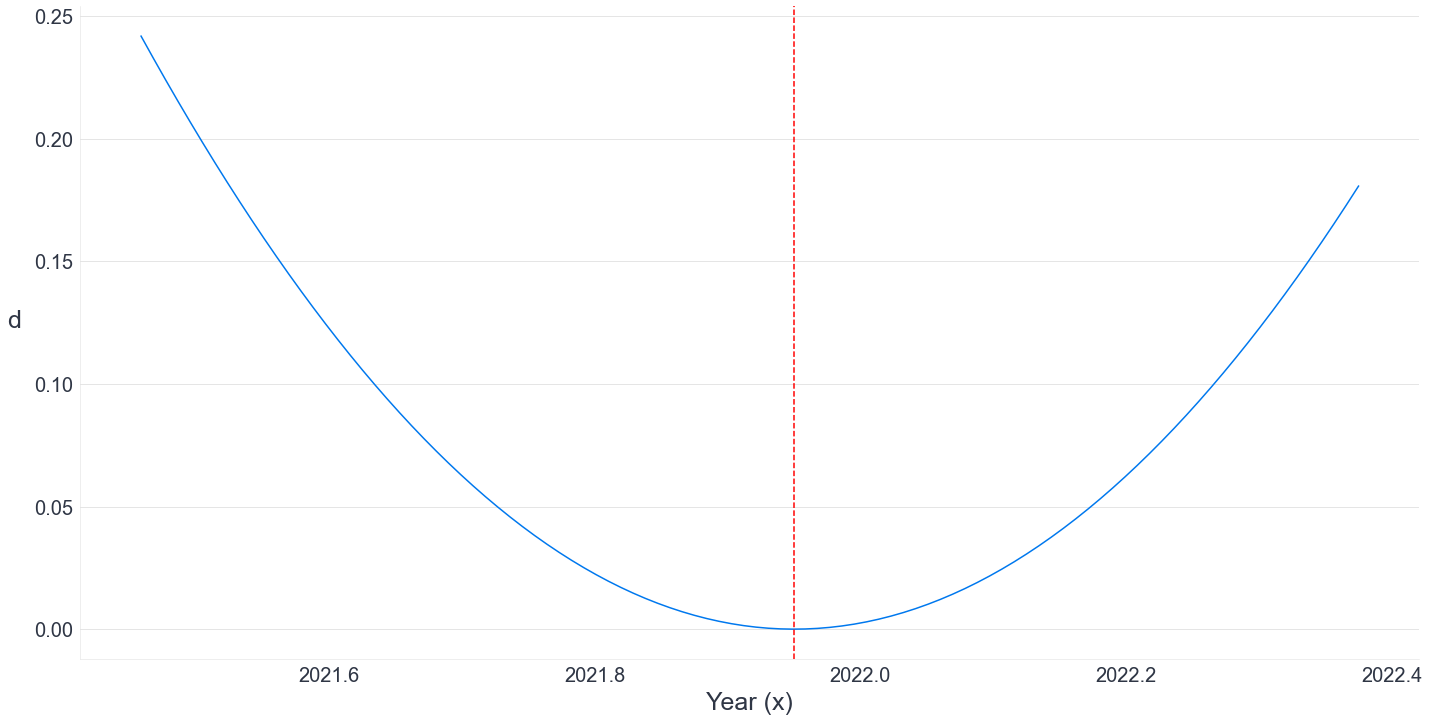

In [122]:
fig = plt.figure(figsize=figsize)

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 100)
x_prime = date_of_interest

plt.plot(x, np.square(x - x_prime));

plt.axvline(x=date_of_interest, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

plt.ylabel("d", rotation=0, labelpad=20);
plt.xlabel("Year (x)");

To help build our intuition, this is a plot of $d$ as a function of $x$, where $x' = 2022.0$.  You can see that as we get further and further away from our test point $x'$, the distance increases.  That's kind of obvious right?  But also think about the *way* the distance increases. 

And just to plant the seed so you start thinking about it, when we're making modeling choices now, we are thinking about things like, how does our data change with distance?  Choices about whether we square, or absolute value, or as we'll see later, use other types of measures entirely will be the crux the model. There isn't a "right" distance to use, that's determined by the data and you.  

## How far is far?


$$
\begin{align}
d &= \left( \frac{x}{\ell} - \frac{x'}{\ell} \right)^2 \\
  &= \left( \frac{x - x'}{\ell} \right)^2 \\
  &= \frac{(x - x')^2}{\ell^2}  \\
\end{align}
$$


In that spirit, we introduce a very important parameter $\ell$, called the *lengthscale*.  As we'll see later, the idea of a lengthscale is very common in GP modeling -- we'll be talking about it a lot in the future.  It's used to scale the distance, and it answers the question of, what exactly counts as close, and what exactly counts as far?  It's role is to sort of standardize the distances by scaling each $x$, and $x'$,




## Most common form

$$
\huge
\begin{align}
d &= \frac{(x - x')^2}{\ell^2}  \\
\end{align}
$$

The last one is usually how it's written. We want to show it to you because you'll often see it in literature and we 'd like you to be prepared.

We're done with the mathematical definition of distance function now!

## The effect of the length scale parameter

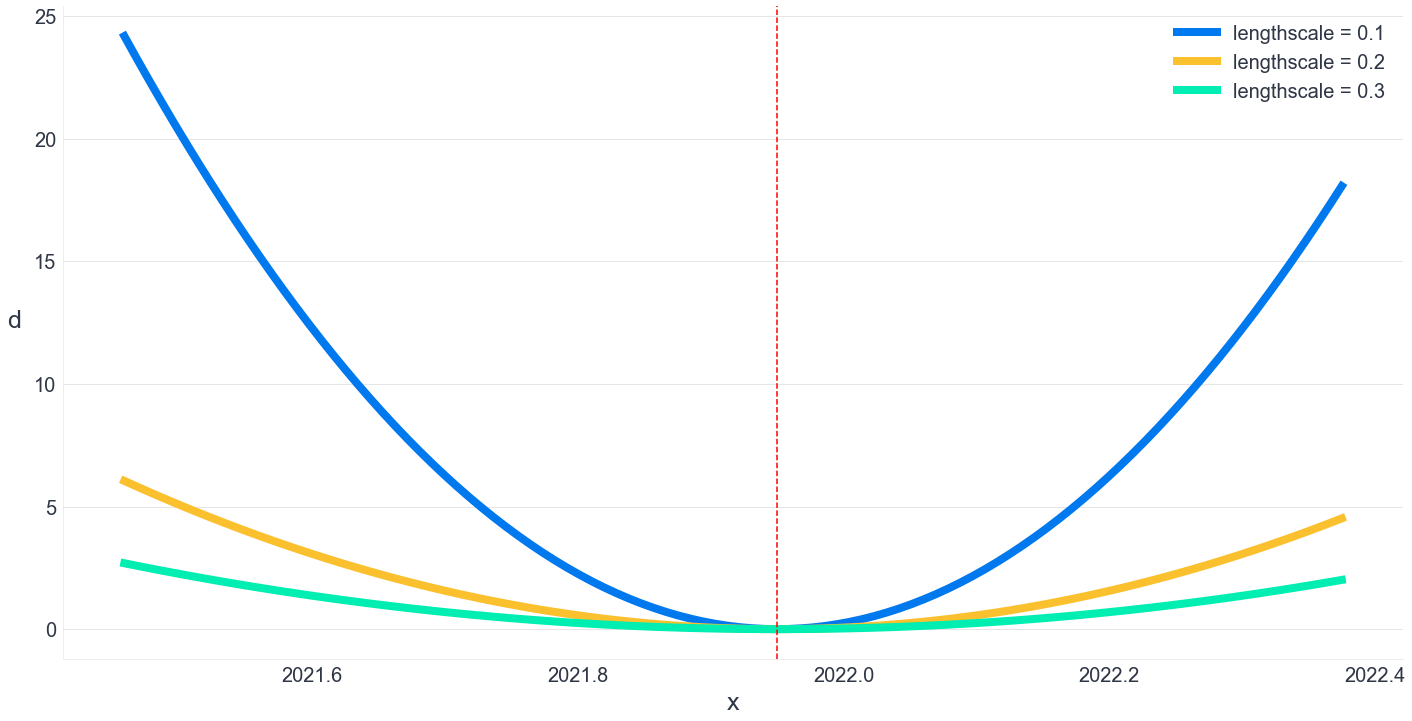

In [123]:
fig = plt.figure(figsize=figsize)

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 100)
x_prime = date_of_interest

lengthscales = [0.1, 0.2, 0.3]

for ell in lengthscales:
    plt.plot(x, np.square((x - x_prime) / ell), label=f"lengthscale = {ell}", lw=8);

plt.axvline(x=x_prime, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);
plt.ylabel("d", rotation=0, labelpad=20)
plt.xlabel("x");
plt.legend(fontsize=20);

Let's play with what we have in code.  Let's remake the previous plot, but try a few different lengthscales (for you sticklers out there, you could've said that we already had a lengthscale, just that it was equal to one).  

By scaling $x$ with $\ell$, we're changing what counts as "far".  Keep in mind that this is all relative to x.

* When $\ell$ is large, like 0.3 here, the distance increases slowly, it's almost flat.  It means we think of points to the far left or far right of $x'$ as not really being that far away.  You've got to go pretty far, relatively, to make the distance $d$ large. 
* When $\ell$ is small, like 0.1 here, the distance increases rapidly.  It doesn't take much distance, to get far away.  

## Short Length Scale: Walking from LA to New York 

<center>
     <img src="img/LatoNYWalk.png"/>
</center>

The length scale is like your mode of transportation.  It's very, very far from New York to LA.  Google says it would take 918 hours to walk there.  That's like a short length scale -- small steps.  Looking at a map of America, everything is far if you're walking.  

## Medium Length Scale: Walking from LA to New York 

<center>
     <img src="img/LaToNYDrive.png"/>
</center>


If you drive however, Google says it would take 41 hours.  Better! 


## Long Length Scale: Flying from LA to New York 

<center>
     <img src="img/LatoNYFly.png"/>
</center>


Flying is like a long lengthscale.  For that one Google says 5 hours and 35 minutes.  Whether you're flying to LA, or Florida, or Chicago, it's all about the same more or less -- a few hours.  You wouldn't say that if you were walking! 

## Similarity
$$ \large
k(x, x'\,; \ell) = \exp \left[  \frac{(x - x')^2}{2*\ell^2} \right]
$$


Also known as RBF (radial basis function) or **exponentiated quadratic** kernel.  



How can we use our new distance function to scale the data?  There are a couple small steps we still need to take.  First, our distance function goes from $\infty$ (far) to zero (close).  For this (and so many other ML algorithms!) we want things in terms of similarity instead of distance.  We're going to call our similarity function $k$ for kernel.  It's mainly function of $x$, but if you think about it, $x'$ too.  Also, the lengthscale is a parameter in there too.  It's a bit different than $x$ and $x'$ or course, so we'll separate it a bit for readability. 

Remember, we need our data points that are close together to have a higher weight, or similarity, than those that are far apart.  One way to accomplish this is to exponentiate $d$, and stick a minus sign up in there.  





## Almost Gaussian, but not that Gaussian



$$ \large
k(x, x'\,; \ell) = \exp \left[  \frac{(x - x')^2}{2*\ell^2} \right]
$$


You might recognize this as *almost* a normal, or Gaussian distribution.  It's a coincidence.  This is NOT where the name "Gaussian" in Gaussian process comes from.  We'll see where it comes from in the next lesson.  We'll see in upcoming lessons that there are **many** different similarity functions you could make.  It's actually fairly common to change this one to use absolute value instead of squaring the distance.

## Weighting function

In [126]:
# Quadratic Kernel in code
x_prime = date_of_interest

def kernel(x, x_prime, lengthscale):
    return np.exp( -1.0 * np.square(x - x_prime) / np.square(lengthscale))

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)
weights = kernel(x, x_prime, 0.1)

TypeError: plot_data() takes 0 positional arguments but 1 was given

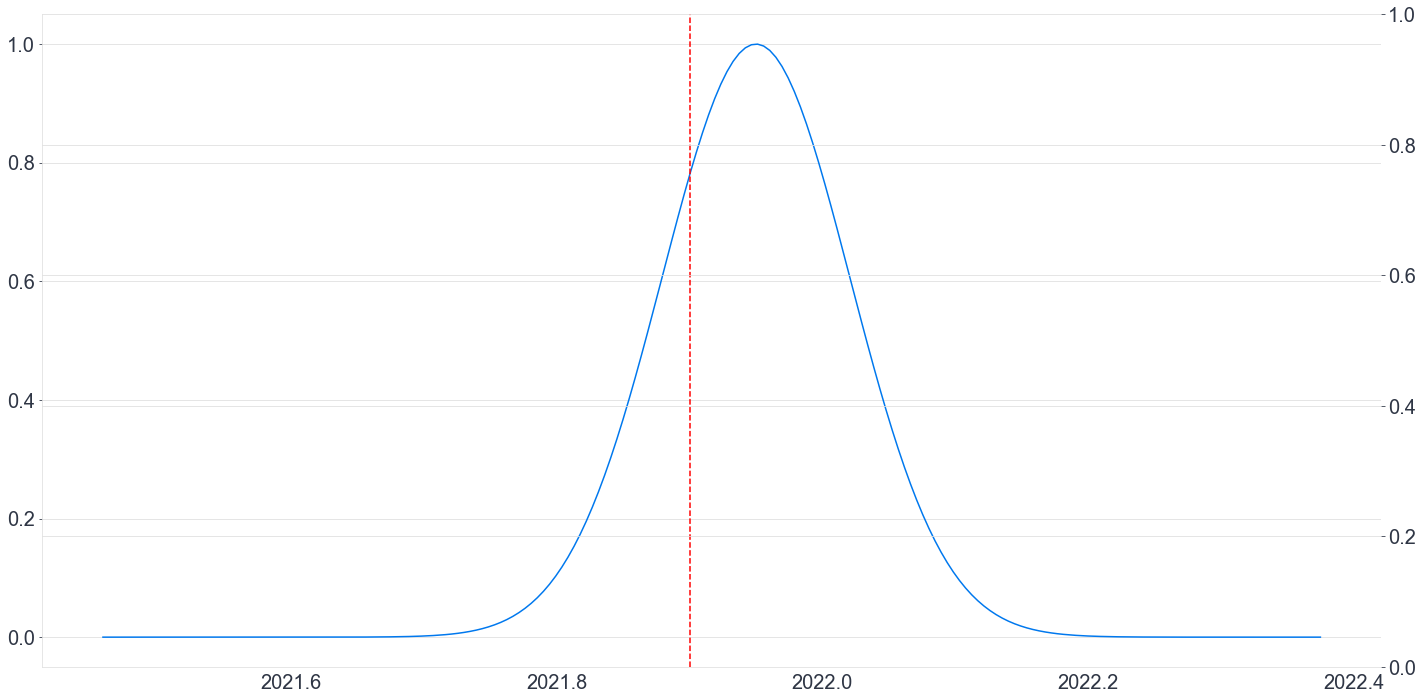

In [139]:
fig = plt.figure(figsize=figsize)


plt.plot(x, weights,label=f"lengthscale = {ell}");

plt.axvline(x=date_of_interest, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

ax.set_ylabel("$k(x, x'\,; \ell)$\n Similarity", rotation=0, loc="center", labelpad= 60);
ax.set_xlabel("x");


ax = plt.gca()
ax2 = ax.twinx()
ax2 = plot_data(ax2)
ax2.grid(False);

Let's make the same kinds of plots we did with distance, except using the kernel function.  Also, we'll overlay our data, so we can see the similarities assigned to the points near $x'$.   

## Building the kernel machine

In [132]:
def kernel_machine(x, y, x_prime, lengthscale):
    k = kernel(x, x_prime, lengthscale)
    w = k / np.sum(k)
    estimate = np.dot(w, y)
    return estimate

Now the last step.  Let's make a super simple kernel regression machine.  Let's use our kernel to calculate weights for each data point, then, we'll normalize them so that they all sum to 1.  Our estimator at $x'$, will be given by this weighted average.  We'll make the same plot, but show the estimate our kernel machine gives.  The kernel machine's estimate is the weighted sum of the datapoints under the "umbrella" of the kernel function.

## Using our machine to make an estimate 

In [133]:
x_prime = date_of_interest
lengthscale = 0.1
x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)

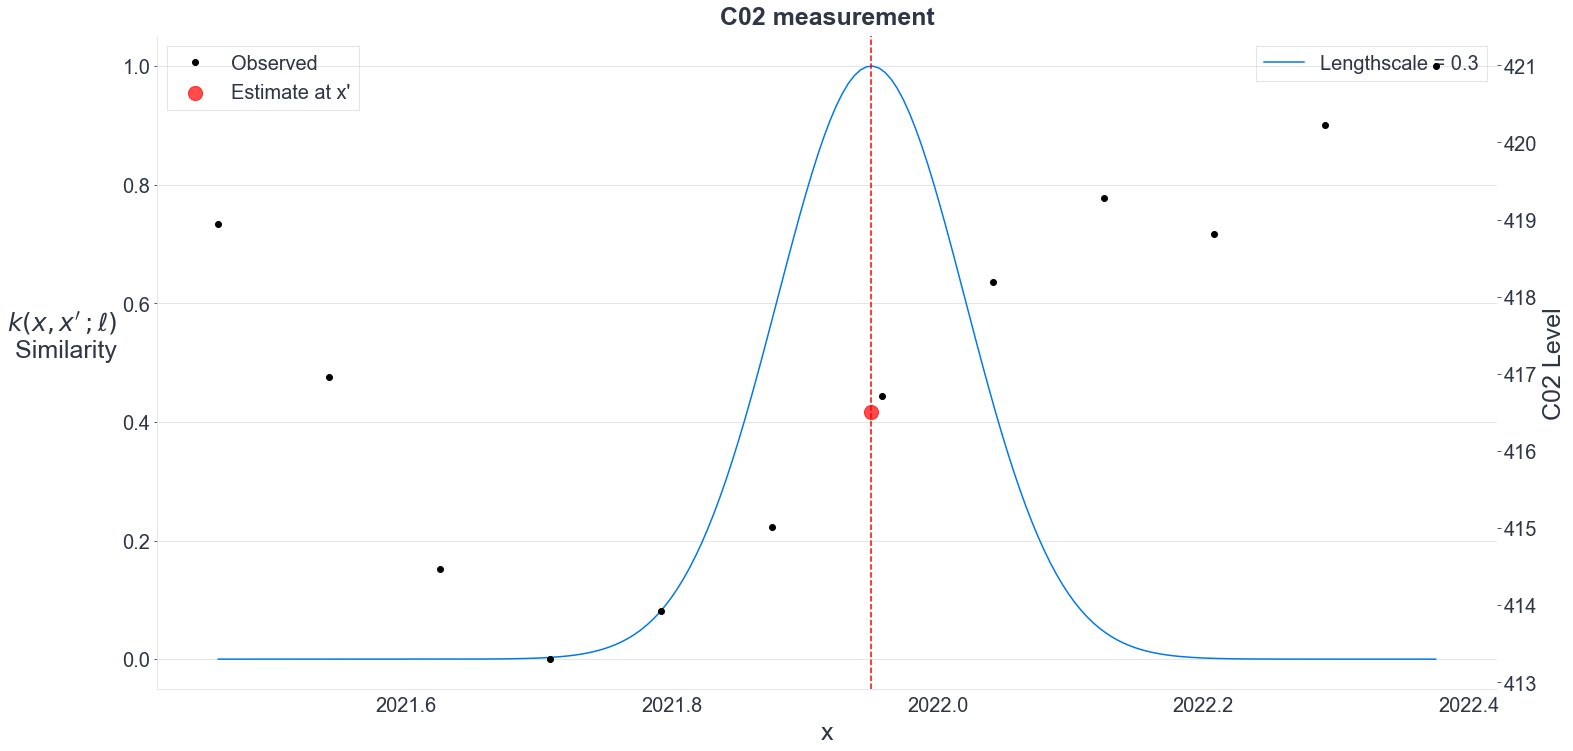

In [134]:
fig = plt.figure(figsize=figsize)

plt.plot(x, kernel(x, x_prime, lengthscale), label=f"Lengthscale = {ell}");
## plot vertical line at x_prime = 2022.0
plt.axvline(x=x_prime, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);
plt.legend(fontsize=20, frameon=True);

## labels
plt.ylabel("$k(x, x'\,; \ell)$\n Similarity", rotation=0, loc="center", labelpad= 60);
plt.xlabel("x");

## overlay real data, new scale
ax = plt.gca()
ax2 = ax.twinx()
ax2 = plot_data(ax2)
ax2.grid(False);

## calculate estimate and plot it
estimate = kernel_machine(
    last_12_obs["decimal date"].values, 
    last_12_obs["average"].values, 
    x_prime, 
    lengthscale,
)
ax2.scatter([x_prime], [estimate], color="r", marker="o", s=200, label="Estimate at x'", alpha=0.7);

plt.legend(fontsize=20, frameon=True);

Looks pretty good!  Now lets drop the plot of the kernel function itself, and look at the fit the kernel machine gives at many $x'$ values across the domain.

## Making C02 estimates for *every* x

''

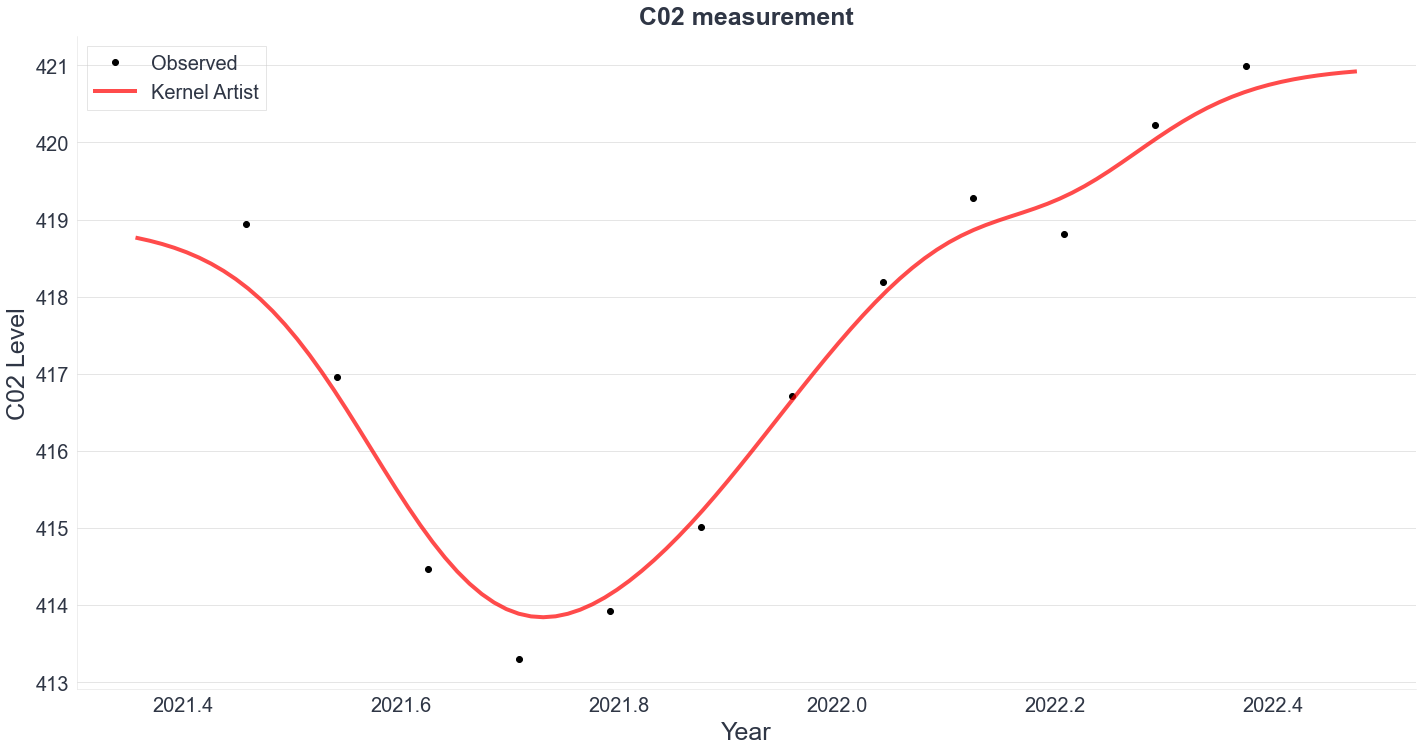

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plot_data(ax)

lengthscale = 0.1

x_range = np.linspace(last_12_obs["decimal date"].min() - 0.1, last_12_obs["decimal date"].max() + 0.1, 100)
estimates = []
for x_prime in x_range:
    estimates.append(kernel_machine(
        last_12_obs["decimal date"].values, 
        last_12_obs["average"].values, 
        x_prime, 
        lengthscale,
    ))
    
ax.plot(x_range, estimates, color="r", alpha=0.7, lw=4, label="Kernel Artist")
plt.legend(fontsize=20, frameon=True);

Much better!  This is clearly the best fit we've been able make so far, whether we are using specific functional forms, or nearest neighbors.  This still isn't a Gaussian process though (the full, stochastic, Jackson Pollock)!  Maybe right now, we kind of know how to make the brush strokes, but not the full picture.  Still, this is an important milestone.

Kernels are a **really, really** important concept in machine learning and statistics.  So much theory is built on them.  It's really a much larger and broader topic than Gaussian processes themselves!  All the intuition we've picked up here, applies just as well to any kernel-based method as it does to GPs.  There are also many, many other fascinating kernels out there -- each describing some other notion of similarity, that allows us to build really effective models.  We'll learn a lot more about them too later in the course. 


## What are we missing?


- This is Intuitive Bayes, so, where's the Bayes??  
  - Are GPs Bayesian?
- The estimates look good, but we have no sense of uncertainty! 
  - What is the range of "viable fit lines" here?
- How do we choose the lengthscale?  
  - Can we put prior on it?
- This is a simple time series...
  - what other types of data can we model?


While this does take us most of the way, we still have a few questions to answer before we have a full GP.  The kernel is one of the major parts.  The other is the multivariate normal probability distribution.  We'll learn about that in the next section.  Putting these two concepts together gives us the Gaussian process.  
What questions are left then?  In later lessons, we'll learn more about

## Section Recap
**This is just a proposal for now**

* Took our nearest neighbors function and added the idea of distance
* The distance from our x', point of interest, to the observed x defines their weight
* Can control the effect of distance with length scale
  * Larger length scales compress the distance
* Built a function that estimates the y C02 value at every x'


## The full Gaussian Process
The artist you've been waiting for


This may seem like a lot of moving pieces, but taken together, the result is simple and I think, pretty elegant, and very useful.  In PyMC, coding up a non-trivial GP model for the complete Mauna Loa data looks like this:

In [251]:
## Prepare data
x = data["decimal date"].values - data["decimal date"].min()

y_mu = data["average"].mean()
y_sd = data["average"].std()
y = (data["average"].values - y_mu) / y_sd

y = data["average"].values

In [307]:
## Make a new kernel!
class RandomWalk(pm.gp.cov.Covariance):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])

    def full(self, X, Xs=None):
        if Xs is None:
            Xs = X
        return at.minimum(X, at.transpose(Xs)) 

    def diag(self, X):
        return at.reshape(X, (-1, ))

In [332]:
## PyMC model

coords = {'time': subset['decimal date'].values}
with pm.Model(coords=coords) as model:
    
    # annual periodic component that decays over time
    eta_per = pm.HalfNormal("eta_per", sigma=10)
    ell_pdecay = pm.Gamma("ell_pdecay", alpha=10, beta=0.075)
    ell_psmooth = pm.Gamma("ell_psmooth ", alpha=4, beta=3)
    period = 1.0 # annual cycles
    cov_seasonal = (
        eta_per**2 * pm.gp.cov.Periodic(1, period, ell_psmooth) * pm.gp.cov.ExpQuad(1, ell_pdecay)
    )
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    eta_med = pm.HalfNormal("eta_med", sigma=10.0)
    ell_med = pm.Gamma("ell_med", alpha=2, beta=0.5)
    cov_medium = eta_med ** 2 * pm.gp.cov.Matern32(1, ell_med)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    eta_trend = pm.HalfNormal("eta_trend", sigma=50.0)
    ell_trend = pm.Gamma("ell_trend", alpha=12.0, beta=0.1)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(1, ell_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)
    
    # short term random walk
    eta_rw = pm.HalfNormal("eta_rw", sigma=1.0)
    cov_rw = eta_rw**2 * RandomWalk()
    gp_rw = pm.gp.Marginal(cov_func=cov_rw)
    
    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_trend + gp_medium + gp_rw 

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    likelihood = gp.marginal_likelihood("likelihood", X=x[:, None], y=y, noise=sigma, dims="time")

In [333]:
## Inference using ADVI

with model:
    mean_field = pm.fit(
        method="advi", 
        callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")],
        obj_optimizer=pm.adamax(learning_rate=0.1),
    )

Interrupted at 1,665 [16%]: Average Loss = 245.66


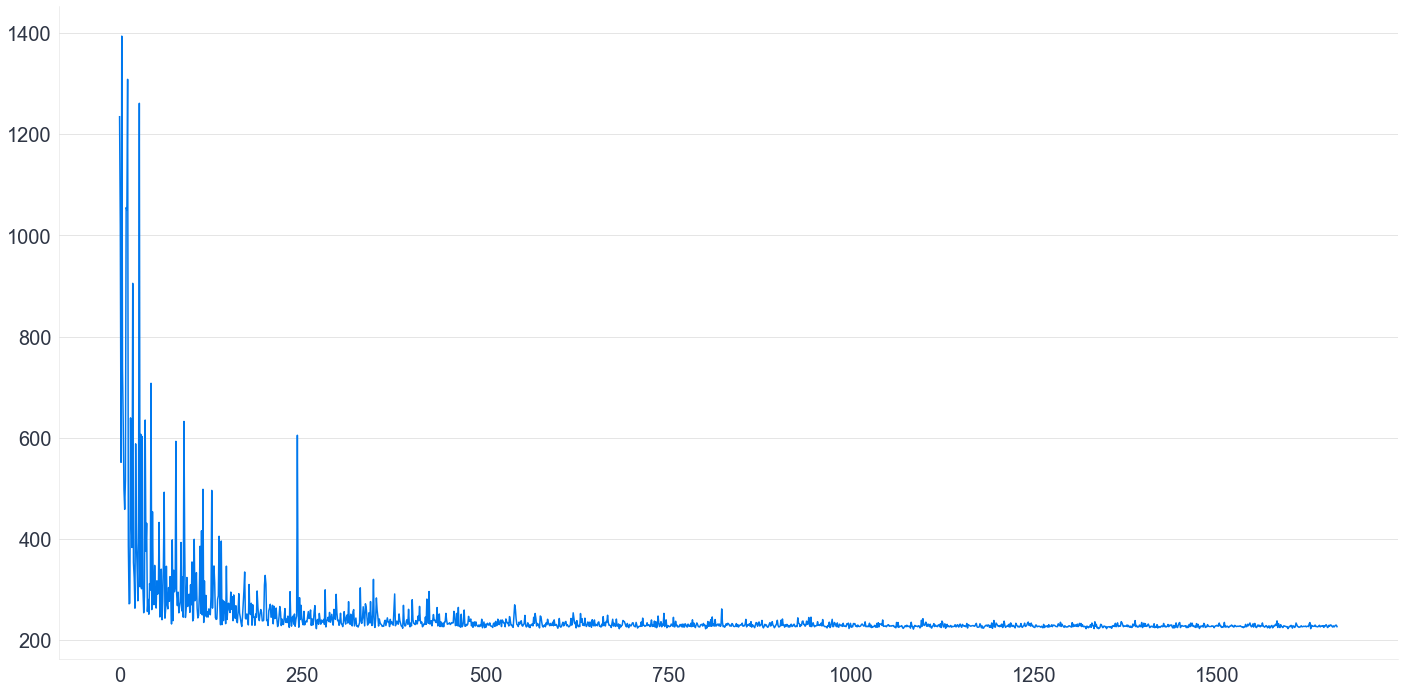

In [334]:
plt.figure(figsize=figsize)
plt.plot(mean_field.hist);

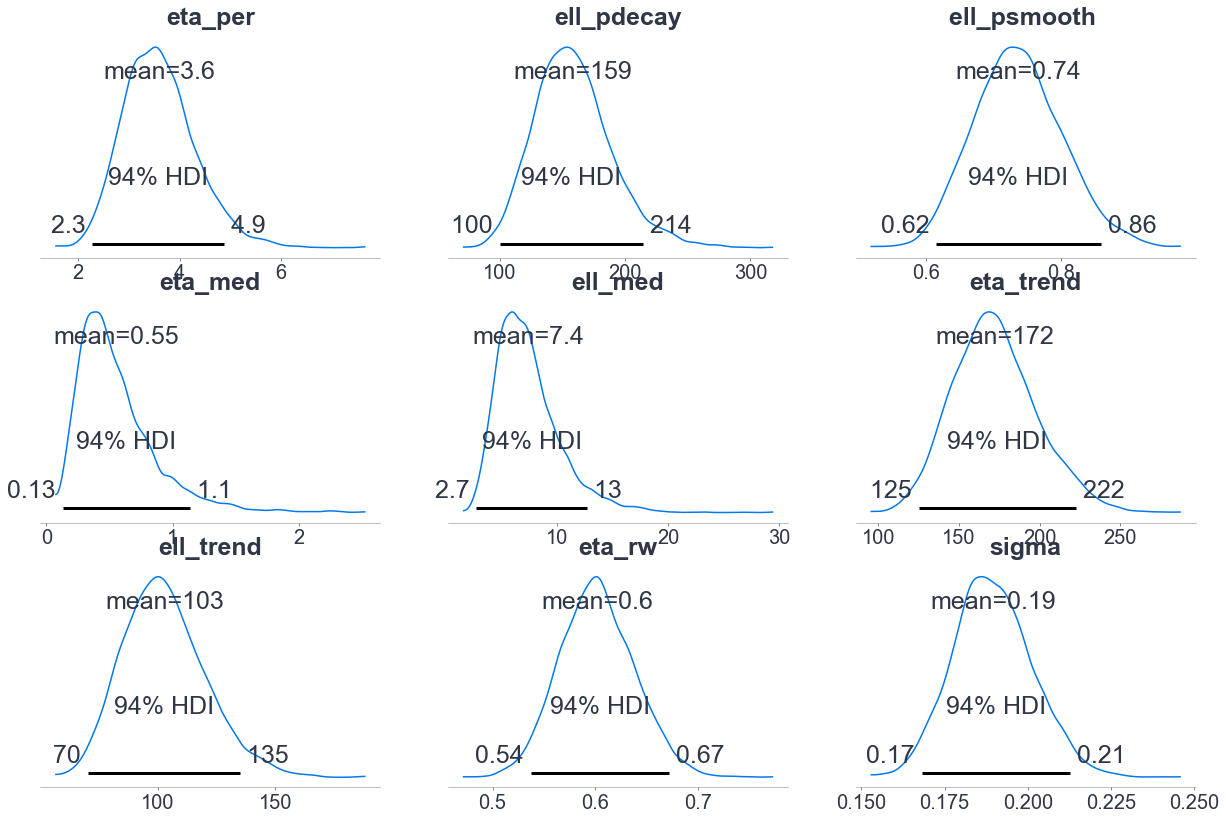

In [338]:
idata = mean_field.sample(5000)
az.plot_posterior(idata);

In [336]:
## Generate fit and forecast

xnew = np.linspace(2000, 2040, 300)
xnew = xnew - subset["decimal date"].min()
with model:
    f = gp.conditional('f', Xnew=xnew[:, None])
    ppc = pm.sample_posterior_predictive(idata, samples=500, var_names=['f'], return_inferencedata=False)

/var/folders/ph/dzn92qs11xxgr9vnqs2mt2z40000gq/T/ipykernel_52986/70176128.py:7: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  ppc = pm.sample_posterior_predictive(idata, samples=500, var_names=['f'], return_inferencedata=False)


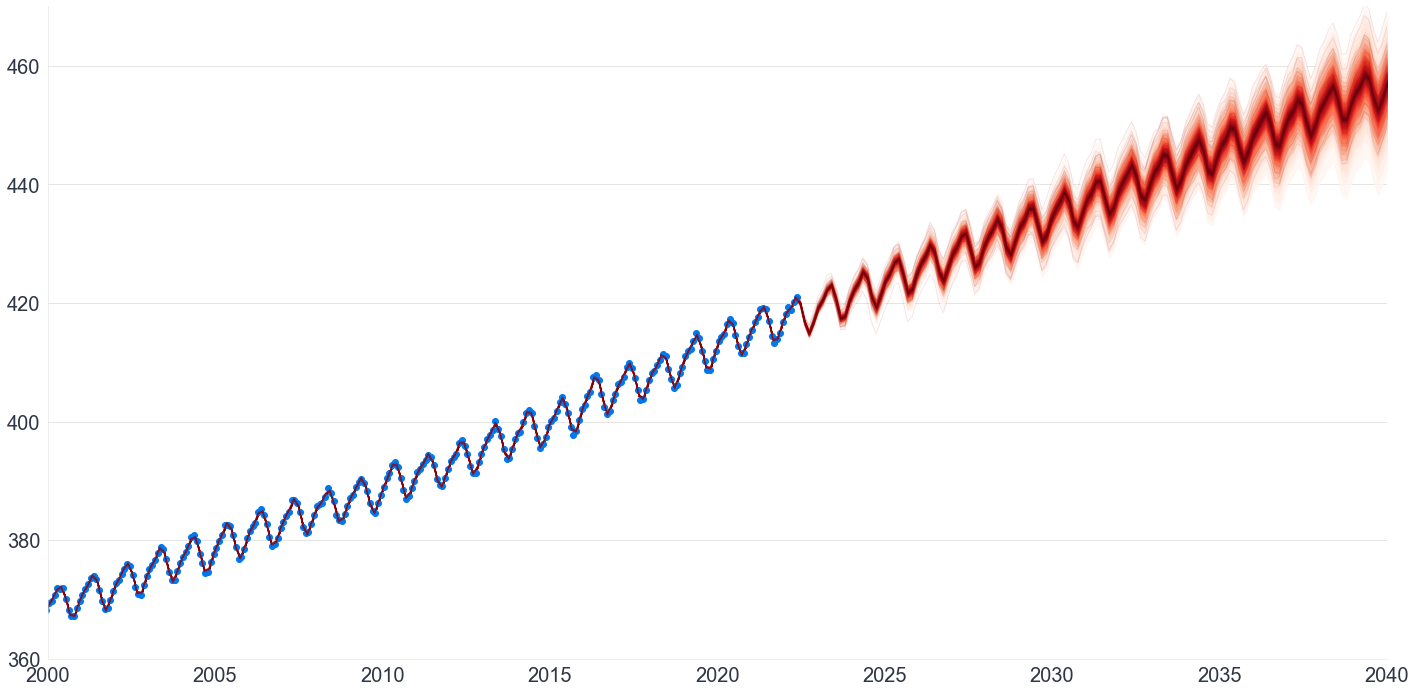

In [341]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plt.plot(subset['decimal date'], subset['average'], 'o');

pm.gp.util.plot_gp_dist(ax, ppc['f'], xnew + subset["decimal date"].min());

plt.xlim([2000, 2040]);
plt.ylim([360, 470]);

In [342]:
## Calculate the MAP (maximum a-posteriori) point from our ADVI fit 
mp = {name: float(val) for name, val in dict(idata.posterior.mean()).items()}

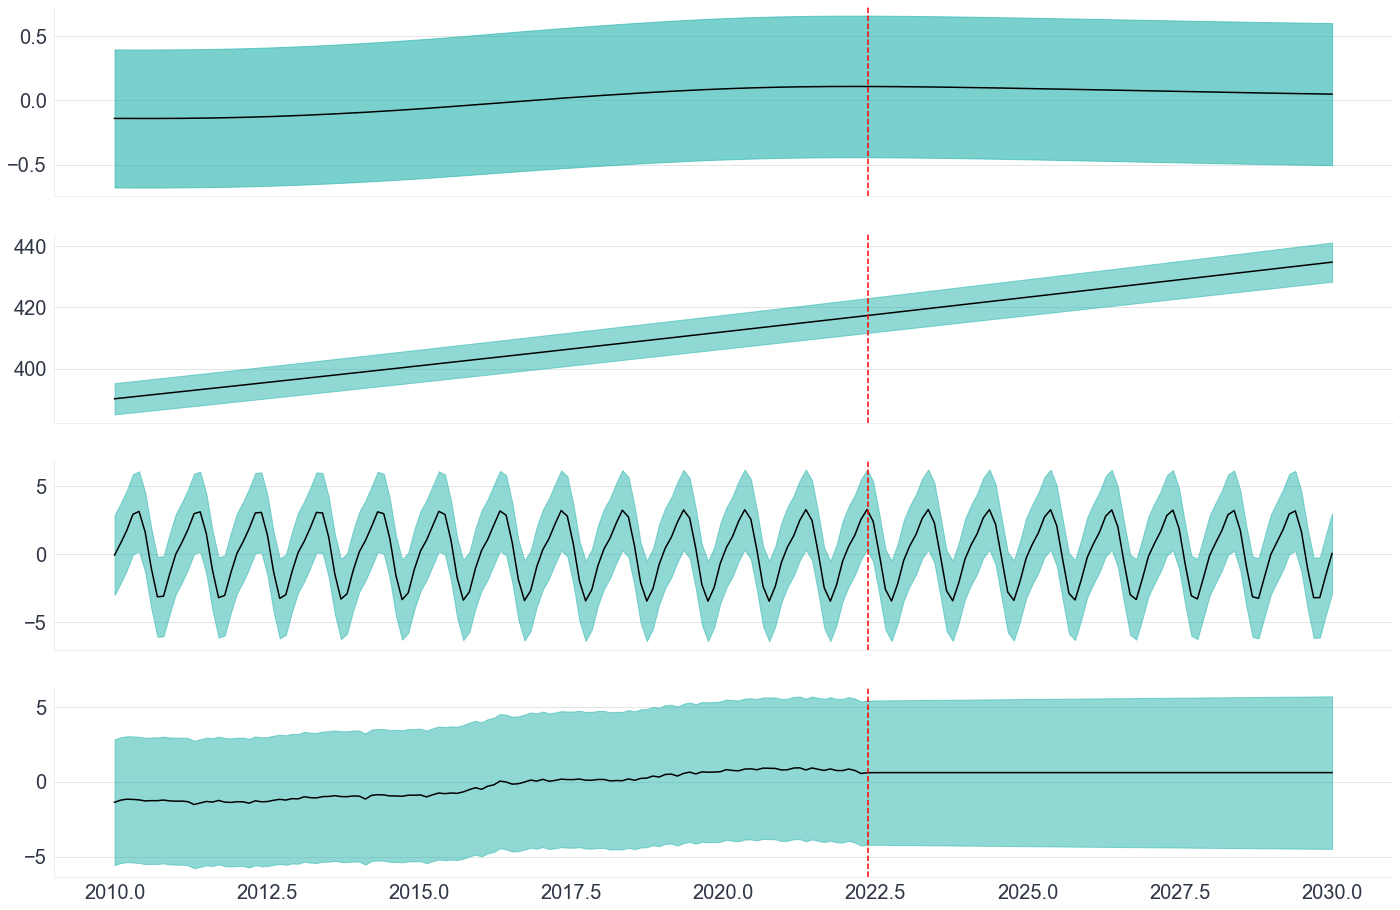

In [343]:
## Plot the three components (keep this?)

fig, axs = plt.subplots(4, 1, figsize=(24, 16), sharex=True)
axs = axs.flatten()

xnew = np.linspace(2010, 2030, 200)
xnew = xnew - subset["decimal date"].min()
with model:
    mu, var = gp_medium.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[0].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.6);
    axs[0].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[0].axvline(x=data["decimal date"].max(), color="r", linestyle="--");

with model:
    mu, var = gp_trend.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[1].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.5);
    axs[1].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[1].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
with model:
    mu, var = gp_seasonal.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[2].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.5);
    axs[2].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[2].axvline(x=data["decimal date"].max(), color="r", linestyle="--");

with model:
    mu, var = gp_rw.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[3].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.5);
    axs[3].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[3].axvline(x=data["decimal date"].max(), color="r", linestyle="--");